In [103]:
import numpy as np 
import pandas as pd
import re 

# Projeto

Um trabalho desenvolvido na disciplina de Machine Learning (Estatística-UFSM) para aplicar as técnicas de ML visando predizer o vencedor da Copa do Mundo FIFA 2022, simulando partida a partida da fase de grupo até a grande final.

Utilizando dois datasets como fontes [International football results from 1872 to 2022](https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017) e [FIFA World Ranking 1992-2022](https://www.kaggle.com/datasets/cashncarry/fifaworldranking).

A estruturação do feature engineering presente nesse trabalho foi desenvolvida em [Soccer World Cup 2018 Winner](https://www.kaggle.com/code/agostontorok/soccer-world-cup-2018-winner). No entanto, foi realizado uma metodologia buscando uma acurácia melhor, adicionando pouca complexidade (covariáveis) ao modelo. 

Os modelos utilizados são para classificação binária para simplificação da modelagem e estruturação das variáveis, assim os modelos são para predizer vitória/derrota, com as partidas que foram empates sendo excluídas da modelagem. A probabilidade de vencer a partida é dada como a média de vencer a partida dentro de casa e fora de casa (pois na copa do mundo não tem vantagem de mandante).

O autor da modelagem para a previsão do vencedor da Copa do Mundo de 2018, que utilizei como base desse projeto, também realizou a modelagem para a Copa de 2022, estando disponível em [Predicting FIFA 2022 World Cup with ML](https://www.kaggle.com/code/sslp23/predicting-fifa-2022-world-cup-with-ml).

# Preparação dos dados

A principal e parte mais trabalhosa desse projeto com certeza é a preparação de dados, anteriormente até ao feature engineering.

Sendo essa parte  diretamente para a construção e desenvolvimento do feature engineering para a criação da base de dados para finalmente ser possível a aplicação dos métodos de ML. 

In [104]:
df =  pd.read_csv("data/results.csv")

In [105]:
df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False


In [106]:
df.dtypes

date           object
home_team      object
away_team      object
home_score    float64
away_score    float64
tournament     object
city           object
country        object
neutral          bool
dtype: object

In [107]:
df["date"] = pd.to_datetime(df["date"])

In [108]:
df.isna().sum()

date           0
home_team      0
away_team      0
home_score    48
away_score    48
tournament     0
city           0
country        0
neutral        0
dtype: int64

In [109]:
df = df.dropna()

The dataset used will be the FIFA Games between 2018, from after the 2018 World Cup to the last games before the 2022 World Cup. The idea is to analyze just the games played at the preparation and classification to WC.

In [110]:
df[(df["date"] >= "2018-6-14")].reset_index(drop=True)['date'].min()

Timestamp('2018-06-14 00:00:00')

In [111]:
df = df.query("date >= '2018-6-14'").reset_index(drop=True)

In [112]:
df.home_team.value_counts()

United States    45
Mexico           43
Qatar            40
South Korea      39
Brazil           39
                 ..
Bhutan            1
Tonga             1
Alderney          1
Saint Helena      1
Chameria          1
Name: home_team, Length: 247, dtype: int64

In [113]:
rank = pd.read_csv("data/fifa_ranking-2022-10-06.csv")

In [114]:
rank.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
0,1,Germany,GER,57.0,0.0,0,UEFA,1992-12-31
1,96,Syria,SYR,11.0,0.0,0,AFC,1992-12-31
2,97,Burkina Faso,BFA,11.0,0.0,0,CAF,1992-12-31
3,99,Latvia,LVA,10.0,0.0,0,UEFA,1992-12-31
4,100,Burundi,BDI,10.0,0.0,0,CAF,1992-12-31


In [115]:
rank["rank_date"] = pd.to_datetime(rank["rank_date"])
rank = rank.query("rank_date >= '2018-6-14'").reset_index(drop=True)

Some teams in the World Cup have different names in the ranking's dataset. So, it's needed to adjust. 

In [116]:
rank["country_full"] = rank["country_full"].str.replace("IR Iran", "Iran").str.replace("Korea Republic", "South Korea").str.replace("USA", "United States")

The merge is made in order to get a dataset FIFA games and its rankings.

O método **ffill** propaga a última informação até a próxima informação válida

In [117]:
rank = rank.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()

In [118]:
rank.head()

,rank_date,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation
0,2018-07-01,146.0,Afghanistan,AFG,1161.0,1161.0,0.0,AFC
1,2018-07-02,146.0,Afghanistan,AFG,1161.0,1161.0,0.0,AFC
2,2018-07-03,146.0,Afghanistan,AFG,1161.0,1161.0,0.0,AFC
3,2018-07-04,146.0,Afghanistan,AFG,1161.0,1161.0,0.0,AFC
4,2018-07-05,146.0,Afghanistan,AFG,1161.0,1161.0,0.0,AFC


### Little feature engineering

Categorizando os times no ranking da FIFA de acordo com sua pontuação, assim a pontuação se torna menos importante, mas sim o nível global da seleção. 

Os níveis serão:

* Classe S => Mais de 1700 pontos
* Classe S- => Entre 1600 e 1700 pontos
* Classe A => Entre 1400 e 1600 pontos
* Classe B => Entre 1200 e 1400 pontos
* Classe C => Entre 1000 e 1200 pontos
* Classe D => Entre 0 e 1000 pontos 

In [119]:
dates = rank['rank_date'].unique()

In [120]:
len(rank)

329074

In [121]:
rank['country_classification'] = None
for date in dates:
    max_points = rank.loc[rank['rank_date'] == date, :]['total_points'].max()
    conditions = [
                (rank.loc[rank['rank_date'] == date, ['total_points']].le(max_points - 800)),
                (rank.loc[rank['rank_date'] == date, ['total_points']].gt(max_points - 800) & rank.loc[rank['rank_date'] == date, ['total_points']].le(max_points - 600)),
                (rank.loc[rank['rank_date'] == date, ['total_points']].gt(max_points - 600) & rank.loc[rank['rank_date'] == date, ['total_points']].le(max_points - 400)),
                (rank.loc[rank['rank_date'] == date, ['total_points']].gt(max_points - 400) & rank.loc[rank['rank_date'] == date, ['total_points']].le(max_points - 200)),
                (rank.loc[rank['rank_date'] == date, ['total_points']].gt(max_points - 200) & rank.loc[rank['rank_date'] == date, ['total_points']].le(max_points - 100)),
                (rank.loc[rank['rank_date'] == date, ['total_points']].gt(max_points - 100)),
            ]

    choices = [10, 8, 6, 4, 2, 1]

    rank.loc[rank['rank_date'] == date, ['country_classification']] = np.select(conditions, choices)

In [122]:
rank.loc[rank['country_full'] == 'Russia', :]

,rank_date,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,country_classification
243258,2018-07-01,49.0,Russia,RUS,1758.00,1707.00,-12.0,UEFA,6
243259,2018-07-02,49.0,Russia,RUS,1758.00,1707.00,-12.0,UEFA,6
243260,2018-07-03,49.0,Russia,RUS,1758.00,1707.00,-12.0,UEFA,6
243261,2018-07-04,49.0,Russia,RUS,1758.00,1707.00,-12.0,UEFA,6
243262,2018-07-05,49.0,Russia,RUS,1758.00,1707.00,-12.0,UEFA,6
...,...,...,...,...,...,...,...,...,...
244812,2022-10-02,35.0,Russia,RUS,1493.42,1493.42,0.0,UEFA,4
244813,2022-10-03,35.0,Russia,RUS,1493.42,1493.42,0.0,UEFA,4
244814,2022-10-04,35.0,Russia,RUS,1493.42,1493.42,0.0,UEFA,4
244815,2022-10-05,35.0,Russia,RUS,1493.42,1493.42,0.0,UEFA,4


In [123]:
df_wc_ranked = df.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date", "country_classification"]], left_on=["date", "home_team"], right_on=["rank_date", "country_full"]).drop(["rank_date", "country_full"], axis=1)

df_wc_ranked = df_wc_ranked.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date", "country_classification"]], left_on=["date", "away_team"], right_on=["rank_date", "country_full"], suffixes=("_home", "_away")).drop(["rank_date", "country_full"], axis=1)

In [124]:
df_wc_ranked[(df_wc_ranked.home_team == "Brazil") | (df_wc_ranked.away_team == "Brazil")].tail(10)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,country_classification_home,total_points_away,previous_points_away,rank_away,rank_change_away,country_classification_away
2557,2021-11-11,Brazil,Colombia,1.0,0.0,FIFA World Cup qualification,São Paulo,Brazil,False,1820.36,1811.73,2.0,0.0,1,1618.76,1618.40,16.0,0.0,4
2658,2021-11-16,Argentina,Brazil,0.0,0.0,FIFA World Cup qualification,San Juan,Argentina,False,1738.79,1725.31,6.0,0.0,1,1820.36,1811.73,2.0,0.0,1
2766,2022-01-27,Ecuador,Brazil,1.0,1.0,FIFA World Cup qualification,Quito,Ecuador,False,1448.27,1448.74,46.0,0.0,4,1826.35,1826.35,2.0,0.0,1
2799,2022-02-01,Brazil,Paraguay,4.0,0.0,FIFA World Cup qualification,Belo Horizonte,Brazil,False,1826.35,1826.35,2.0,0.0,1,1454.52,1454.52,43.0,0.0,4
2840,2022-03-24,Brazil,Chile,4.0,0.0,FIFA World Cup qualification,Rio de Janeiro,Brazil,False,1823.42,1826.35,2.0,0.0,1,1543.16,1543.42,26.0,2.0,4
2923,2022-03-29,Bolivia,Brazil,0.0,4.0,FIFA World Cup qualification,La Paz,Bolivia,False,1308.12,1324.21,76.0,-1.0,6,1823.42,1826.35,2.0,0.0,1
3015,2022-06-02,South Korea,Brazil,1.0,5.0,Friendly,Seoul,South Korea,False,1519.54,1522.85,29.0,0.0,4,1832.69,1823.42,1.0,-1.0,1
3083,2022-06-06,Japan,Brazil,0.0,1.0,Friendly,Tokyo,Japan,False,1553.44,1549.82,23.0,0.0,4,1832.69,1823.42,1.0,-1.0,1
3260,2022-09-23,Brazil,Ghana,3.0,0.0,Friendly,Le Havre,France,True,1837.56,1837.56,1.0,0.0,1,1393.47,1389.68,60.0,0.0,6
3329,2022-09-27,Brazil,Tunisia,5.0,1.0,Friendly,Paris,France,True,1837.56,1837.56,1.0,0.0,1,1507.86,1507.86,30.0,0.0,4


Agora, nós temos os dados para criar as variáveis independentes baseadas nos resultados dos jogos e ranking da FIFA, sendo as principais variáveis: o número de gols das equipes, sua colocação no ranking da FIFA e o tipo do jogo.

# Feature Engineering

Com a definição central do DataFrame vamos criar algumas variáveis que tem impacto na predição dos jogos:

- Pontos feitos em jogos anteriores
- Gols marcados e sofridos em partidas anterioees
- Importância da partida (amistoso ou não)
- Posição dos times no ranking da FIFA
- Evolução do ranking das seleções
- Gols sofridos e marcados pelo ranking da equipe

Começaremos definindo os vencedores e perdedores, assim como seus pontos, em cada partida.

In [125]:
df = df_wc_ranked

In [126]:
def result_finder(home, away):
    if home > away:
        return pd.Series([0, 3, 0])
    if home < away:
        return pd.Series([1, 0, 3])
    else:
        return pd.Series([2, 1, 1])

results = df.apply(lambda x: result_finder(x["home_score"], x["away_score"]), axis=1)

In [127]:
df[["result", "home_team_points", "away_team_points"]] = results

O padrão do futebol atual é utilizar 3 pontos para vitória, 1 ponto para empate e 0 para derrota.
O ranking da FIFA é construído com essa base, no entanto a  FIFA utiliza pontuações específicas para cada nível de partida e o adversário enfrentado.
Assim a pontuação da seleção no ranking com sua posição deve ser negativamente correlacionado.

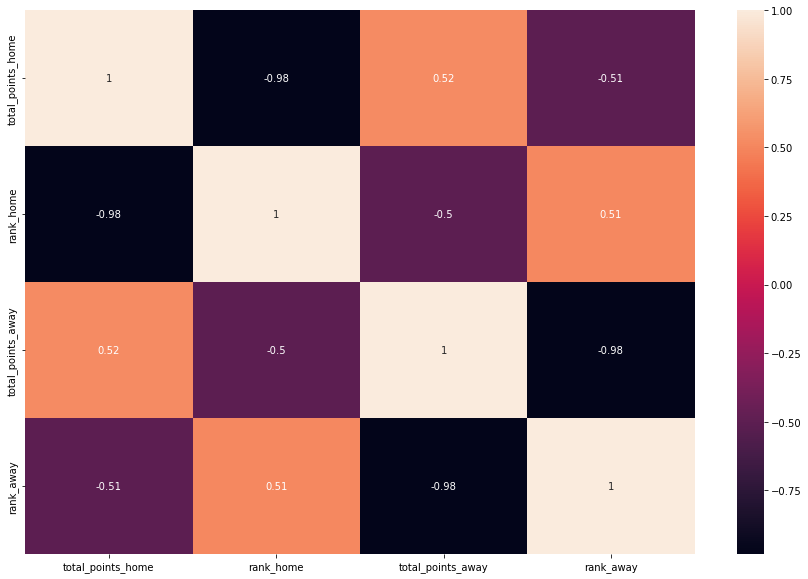

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
sns.heatmap(df[["total_points_home", "rank_home", "total_points_away", "rank_away"]].corr(), annot=True)
plt.show()

Começaremos criando variáveis que iram ajudar a criar outras variáveis: Diferença de Ranking, Diferença de Gols, pontos ganho no jogo pelo ranking do time (quanto maior o ranking, mais vale os pontos). Precisaremos criar as mesmas variáveis para os times da casa, quanto para o time de fora.

In [129]:
df[['home_team', 'away_team', 'home_score', 'away_score', 'total_points_home', 'rank_home', 'rank_away', 'result', 'home_team_points', 'away_team_points', "country_classification_home", "country_classification_away"]].head(10)

,home_team,away_team,home_score,away_score,total_points_home,rank_home,rank_away,result,home_team_points,away_team_points,country_classification_home,country_classification_away
0,Russia,Spain,1.0,1.0,1758.0,49.0,6.0,2,1,1,6,1
1,Croatia,Denmark,1.0,1.0,2036.0,12.0,15.0,2,1,1,2,2
2,Brazil,Mexico,2.0,0.0,2160.0,4.0,10.0,0,3,0,1,2
3,Belgium,Japan,3.0,2.0,2124.0,5.0,41.0,0,3,0,1,4
4,Sweden,Switzerland,1.0,0.0,1955.0,21.0,8.0,0,3,0,4,1
5,Colombia,England,1.0,1.0,1998.0,17.0,7.0,2,1,1,2,1
6,Malaysia,Fiji,1.0,0.0,1004.0,171.0,167.0,0,3,0,10,10
7,Uruguay,France,0.0,2.0,2017.0,14.0,2.0,1,0,3,2,1
8,Brazil,Belgium,1.0,2.0,2160.0,4.0,5.0,1,0,3,1,1
9,Sweden,England,0.0,2.0,1955.0,21.0,7.0,1,0,3,4,1


In [130]:
df["rank_dif"] = df["rank_home"] - df["rank_away"]
df["sg"] = df["home_score"] - df["away_score"]
df["points_home_by_rank"] = df["home_team_points"]/df["rank_away"]
df["points_away_by_rank"] = df["away_team_points"]/df["rank_home"]
df["points_home_by_classification"] = df["home_team_points"]/df["country_classification_away"]
df["points_away_by_classification"] = df["away_team_points"]/df["country_classification_home"]


In [131]:
df[['home_team', 'away_team', 'result','rank_home', 'rank_away', 'home_team_points', 'away_team_points', 'sg', 'rank_dif', 'points_home_by_rank', 'points_away_by_rank', 'points_home_by_classification', 'points_away_by_classification']].head(10)

,home_team,away_team,result,rank_home,rank_away,home_team_points,away_team_points,sg,rank_dif,points_home_by_rank,points_away_by_rank,points_home_by_classification,points_away_by_classification
0,Russia,Spain,2,49.0,6.0,1,1,0.0,43.0,0.166667,0.020408,1.0,0.166667
1,Croatia,Denmark,2,12.0,15.0,1,1,0.0,-3.0,0.066667,0.083333,0.5,0.5
2,Brazil,Mexico,0,4.0,10.0,3,0,2.0,-6.0,0.300000,0.000000,1.5,0.0
3,Belgium,Japan,0,5.0,41.0,3,0,1.0,-36.0,0.073171,0.000000,0.75,0.0
4,Sweden,Switzerland,0,21.0,8.0,3,0,1.0,13.0,0.375000,0.000000,3.0,0.0
5,Colombia,England,2,17.0,7.0,1,1,0.0,10.0,0.142857,0.058824,1.0,0.5
6,Malaysia,Fiji,0,171.0,167.0,3,0,1.0,4.0,0.017964,0.000000,0.3,0.0
7,Uruguay,France,1,14.0,2.0,0,3,-2.0,12.0,0.000000,0.214286,0.0,1.5
8,Brazil,Belgium,1,4.0,5.0,0,3,-1.0,-1.0,0.000000,0.750000,0.0,3.0
9,Sweden,England,1,21.0,7.0,0,3,-2.0,14.0,0.000000,0.142857,0.0,0.75


Para melhorar a criação das features, vamos separar o dataset em dois: time de casa e timede fora, para podermos mensurar o valor dos jogos. Depois disso vamos juntá-los novamente, obtendo o dataset original. Somente para otimizar o processo de criação das features/variáveis.

In [132]:
home_team = df[["date", "home_team", "home_score", "away_score", "rank_home", "rank_away","rank_change_home", "total_points_home", "result", "rank_dif", "points_home_by_rank", "home_team_points", "country_classification_home", "points_home_by_classification"]]

away_team = df[["date", "away_team", "away_score", "home_score", "rank_away", "rank_home","rank_change_away", "total_points_away", "result", "rank_dif", "points_away_by_rank", "away_team_points", "country_classification_away", "points_away_by_classification"]]

In [133]:
home_team.columns = [h.replace("home_", "").replace("_home", "").replace("away_", "suf_").replace("_away", "_suf") for h in home_team.columns]

away_team.columns = [a.replace("away_", "").replace("_away", "").replace("home_", "suf_").replace("_home", "_suf") for a in away_team.columns]

In [134]:
home_team.head()

,date,team,score,suf_score,rank,rank_suf,rank_change,total_points,result,rank_dif,points_by_rank,team_points,country_classification,points_by_classification
0,2018-07-01,Russia,1.0,1.0,49.0,6.0,-12.0,1758.0,2,43.0,0.166667,1,6,1.0
1,2018-07-01,Croatia,1.0,1.0,12.0,15.0,-6.0,2036.0,2,-3.0,0.066667,1,2,0.5
2,2018-07-02,Brazil,2.0,0.0,4.0,10.0,1.0,2160.0,0,-6.0,0.300000,3,1,1.5
3,2018-07-02,Belgium,3.0,2.0,5.0,41.0,-1.0,2124.0,0,-36.0,0.073171,3,1,0.75
4,2018-07-03,Sweden,1.0,0.0,21.0,8.0,-1.0,1955.0,0,13.0,0.375000,3,4,3.0


In [135]:
team_stats = home_team.append(away_team)#.sort_values("date")

C:\Users\user\AppData\Local\Temp\ipykernel_22020\275322566.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  team_stats = home_team.append(away_team)#.sort_values("date")


In [136]:
team_stats.head()

,date,team,score,suf_score,rank,rank_suf,rank_change,total_points,result,rank_dif,points_by_rank,team_points,country_classification,points_by_classification
0,2018-07-01,Russia,1.0,1.0,49.0,6.0,-12.0,1758.0,2,43.0,0.166667,1,6,1.0
1,2018-07-01,Croatia,1.0,1.0,12.0,15.0,-6.0,2036.0,2,-3.0,0.066667,1,2,0.5
2,2018-07-02,Brazil,2.0,0.0,4.0,10.0,1.0,2160.0,0,-6.0,0.300000,3,1,1.5
3,2018-07-02,Belgium,3.0,2.0,5.0,41.0,-1.0,2124.0,0,-36.0,0.073171,3,1,0.75
4,2018-07-03,Sweden,1.0,0.0,21.0,8.0,-1.0,1955.0,0,13.0,0.375000,3,4,3.0


In [137]:
print(f'Para o feature engineering ficar mais simples, tinhamos um dataframe das partidas com {home_team.shape[0]} linhas e agora temos um dataframe com {team_stats.shape[0]}, sendo cada seleção uma linha, sem ser as partidas.')

Para o feature engineering ficar mais simples, tinhamos um dataframe das partidas com 3365 linhas e agora temos um dataframe com 6730, sendo cada seleção uma linha, sem ser as partidas.


In [138]:
#this column will be used to calculate features for simulation
team_stats_raw = team_stats.copy()

Agora, podemos criar algumas variáveis independentes, como:

- Média de gols da seleção no Ciclo da Copa do Mundo.
- Média de gols no time nos últimos 5 jogos.
- Média de gols sofridos do time nos últimos 5 jogos.
- Média de gols sofridos do time no Ciclo da Copa do Mundo.
- Média do Ranking da Fifa dos times enfrentados no Ciclo da Copa do Mundo.
- Média do Ranking da Fifa dos times adversários nos últimos 5 jogos.
- Pontuação FIFA conquistada no Ranking 
- Pontuação FIFA conquistada no Ranking nos últimos jogos.
- Média de pontuação conquistada no ciclo da copa
- Média de pontuação conquistada nos últimos 5 jogos
- Média de pontos conquistados pelo ranking do time adversário no ciclo da copa
- Média de pontos conquistados pelo ranking do time adversário nos últimos 5 jogos
- Média de pontos conquistados pela classificação do time adversário no ciclo da copa
- Média de pontos conquistados pela classificação do time adversário nos últimos 5 jogos

In [139]:
team_stats

,date,team,score,suf_score,rank,rank_suf,rank_change,total_points,result,rank_dif,points_by_rank,team_points,country_classification,points_by_classification
0,2018-07-01,Russia,1.0,1.0,49.0,6.0,-12.0,1758.00,2,43.0,0.166667,1,6,1.0
1,2018-07-01,Croatia,1.0,1.0,12.0,15.0,-6.0,2036.00,2,-3.0,0.066667,1,2,0.5
2,2018-07-02,Brazil,2.0,0.0,4.0,10.0,1.0,2160.00,0,-6.0,0.300000,3,1,1.5
3,2018-07-02,Belgium,3.0,2.0,5.0,41.0,-1.0,2124.00,0,-36.0,0.073171,3,1,0.75
4,2018-07-03,Sweden,1.0,0.0,21.0,8.0,-1.0,1955.00,0,13.0,0.375000,3,4,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3360,2022-09-27,Serbia,2.0,0.0,25.0,36.0,0.0,1549.53,1,11.0,0.083333,3,4,0.75
3361,2022-09-27,Slovenia,1.0,1.0,65.0,20.0,0.0,1372.48,2,-45.0,0.050000,1,6,0.25
3362,2022-09-27,Cyprus,1.0,5.0,108.0,106.0,1.0,1180.52,0,-2.0,0.000000,0,8,0.0
3363,2022-09-27,Northern Ireland,1.0,3.0,58.0,49.0,0.0,1399.10,0,-9.0,0.000000,0,6,0.0


In [140]:
team_stats.shape[0]/2

3365.0

In [141]:
team_stats.iloc[int(team_stats.shape[0]/2)]

date                        2018-07-01 00:00:00
team                                      Spain
score                                       1.0
suf_score                                   1.0
rank                                        6.0
rank_suf                                   49.0
rank_change                                -2.0
total_points                             2104.0
result                                        2
rank_dif                                   43.0
points_by_rank                         0.020408
team_points                                   1
country_classification                        1
points_by_classification               0.166667
Name: 0, dtype: object

In [142]:
team_stats.head()

,date,team,score,suf_score,rank,rank_suf,rank_change,total_points,result,rank_dif,points_by_rank,team_points,country_classification,points_by_classification
0,2018-07-01,Russia,1.0,1.0,49.0,6.0,-12.0,1758.0,2,43.0,0.166667,1,6,1.0
1,2018-07-01,Croatia,1.0,1.0,12.0,15.0,-6.0,2036.0,2,-3.0,0.066667,1,2,0.5
2,2018-07-02,Brazil,2.0,0.0,4.0,10.0,1.0,2160.0,0,-6.0,0.300000,3,1,1.5
3,2018-07-02,Belgium,3.0,2.0,5.0,41.0,-1.0,2124.0,0,-36.0,0.073171,3,1,0.75
4,2018-07-03,Sweden,1.0,0.0,21.0,8.0,-1.0,1955.0,0,13.0,0.375000,3,4,3.0


In [143]:
# for index, row in team_stats.iterrows():
#     print(row)

In [144]:
stats_val = []

for index, row in team_stats.iterrows():
    team = row["team"]
    date = row["date"]
    past_games = team_stats.query("team == @team & date < @date").sort_values(by=['date'], ascending=False)
    last5 = past_games.head(5)
    last10 = past_games.head(10)
    last15 = past_games.head(15)
    last30 = past_games.head(30)
    
    goals = past_games["score"].mean()
    goals_l5 = last5["score"].mean()
    goals_l10 = last10["score"].mean()
    goals_l15 = last15["score"].mean()
    goals_l30 = last30["score"].mean()
    
    goals_suf = past_games["suf_score"].mean()
    goals_suf_l5 = last5["suf_score"].mean()
    goals_suf_l10 = last10["suf_score"].mean()
    goals_suf_l15 = last15["suf_score"].mean()
    goals_suf_l30 = last30["suf_score"].mean()
    
    rank = past_games["rank_suf"].mean()
    rank_l5 = last5["rank_suf"].mean()
    rank_l10 = last10["rank_suf"].mean()
    rank_l15 = last15["rank_suf"].mean()
    rank_l30 = last30["rank_suf"].mean()
    
    if len(last5) > 0:
        points = past_games["total_points"].values[0] - past_games["total_points"].values[-1]#qtd de pontos ganhos
        points_l5 = last5["total_points"].values[0] - last5["total_points"].values[-1] 
        points_l10 = last10["total_points"].values[0] - last10["total_points"].values[-1]
        points_l15 = last15["total_points"].values[0] - last15["total_points"].values[-1]
        points_l30 = last30["total_points"].values[0] - last30["total_points"].values[-1]
    else:
        points = 0
        points_l5 = 0
        points_l10 = 0
        points_l15 = 0
        points_l30 = 0
    
        
    gp = past_games["team_points"].mean()
    gp_l5 = last5["team_points"].mean()
    gp_l10 = last10["team_points"].mean()
    gp_l15 = last15["team_points"].mean()
    gp_l30 = last30["team_points"].mean()
    
    gp_rank = past_games["points_by_rank"].mean()
    gp_rank_l5 = last5["points_by_rank"].mean()
    gp_rank_l10 = last10["points_by_rank"].mean()
    gp_rank_l15 = last15["points_by_rank"].mean()
    gp_rank_l30 = last30["points_by_rank"].mean()

    cp_rank = past_games["points_by_classification"].mean()
    cp_rank_l5 = last5["points_by_classification"].mean()
    cp_rank_l10 = last10["points_by_classification"].mean()
    cp_rank_l15 = last15["points_by_classification"].mean()
    cp_rank_l30 = last30["points_by_classification"].mean()
    
    
    stats_val.append([goals, goals_l5, goals_suf, goals_suf_l5, rank, rank_l5, points, points_l5, gp, gp_l5, gp_rank, gp_rank_l5, cp_rank, cp_rank_l5,
                    goals_l10, goals_l15, goals_l30, goals_suf_l10, goals_suf_l15, goals_suf_l30, rank_l10, rank_l15, rank_l30, points_l10, points_l15, points_l30, 
                    gp_l10, gp_l15, gp_l30, gp_rank_l10, gp_rank_l15, gp_rank_l30, cp_rank_l10, cp_rank_l15, cp_rank_l30])

In [145]:
stats_cols = (["goals_mean", "goals_mean_l5", "goals_suf_mean", "goals_suf_mean_l5", "rank_mean", "rank_mean_l5", 
                "points_mean", "points_mean_l5", "game_points_mean", "game_points_mean_l5", "game_points_rank_mean", "game_points_rank_mean_l5",
                "game_points_by_classification_mean", "game_points_by_classification_mean_l5",
                "goals_mean_l10", "goals_mean_l15", "goals_mean_l30",  "goals_suf_mean_l10", "goals_suf_mean_l15", "goals_suf_mean_l30", 
                "rank_mean_l10", "rank_mean_l15", "rank_mean_l30", "points_mean_l10", "points_mean_l15", "points_mean_l30", 
                "game_points_mean_l10", "game_points_mean_l15", "game_points_mean_l30", 
                "game_points_rank_mean_l10", "game_points_rank_mean_l15", "game_points_rank_mean_l30",
                "game_points_by_classification_mean_l10", "game_points_by_classification_mean_l15", "game_points_by_classification_mean_l30",
                ])

stats_df = pd.DataFrame(stats_val, columns=stats_cols)

In [146]:
stats_df

,goals_mean,goals_mean_l5,goals_suf_mean,goals_suf_mean_l5,rank_mean,rank_mean_l5,points_mean,points_mean_l5,game_points_mean,game_points_mean_l5,...,points_mean_l30,game_points_mean_l10,game_points_mean_l15,game_points_mean_l30,game_points_rank_mean_l10,game_points_rank_mean_l15,game_points_rank_mean_l30,game_points_by_classification_mean_l10,game_points_by_classification_mean_l15,game_points_by_classification_mean_l30
0,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6725,1.800000,2.2,1.111111,1.0,54.533333,42.0,90.53,2.00,1.866667,2.0,...,64.53,2.2,2.133333,1.766667,0.090846,0.070955,0.057199,0.554167,0.502778,0.415278
6726,1.380952,1.0,1.000000,1.8,76.357143,29.2,-19.52,-5.75,1.404762,1.0,...,-17.52,1.1,1.400000,1.533333,0.028775,0.024263,0.027322,0.237500,0.235000,0.262778
6727,0.767442,0.6,1.767442,1.4,70.418605,63.8,-99.48,-5.57,0.767442,1.0,...,-80.48,1.0,0.666667,0.600000,0.014185,0.009456,0.008672,0.168333,0.112222,0.103333
6728,1.023256,1.2,1.279070,1.4,57.906977,95.6,-92.90,-24.45,1.139535,1.0,...,-88.90,1.2,1.266667,1.000000,0.035183,0.031528,0.024201,0.250000,0.233333,0.198889


In [147]:
full_df = pd.concat([team_stats.reset_index(drop=True), stats_df], axis=1, ignore_index=False)

In [148]:
full_df.columns[13]

'points_by_classification'

In [149]:
home_team_stats = full_df.iloc[:int(full_df.shape[0]/2),:]
away_team_stats = full_df.iloc[int(full_df.shape[0]/2):,:]

The new columns:

In [150]:
home_team_stats.columns[-35:]

Index(['goals_mean', 'goals_mean_l5', 'goals_suf_mean', 'goals_suf_mean_l5',
       'rank_mean', 'rank_mean_l5', 'points_mean', 'points_mean_l5',
       'game_points_mean', 'game_points_mean_l5', 'game_points_rank_mean',
       'game_points_rank_mean_l5', 'game_points_by_classification_mean',
       'game_points_by_classification_mean_l5', 'goals_mean_l10',
       'goals_mean_l15', 'goals_mean_l30', 'goals_suf_mean_l10',
       'goals_suf_mean_l15', 'goals_suf_mean_l30', 'rank_mean_l10',
       'rank_mean_l15', 'rank_mean_l30', 'points_mean_l10', 'points_mean_l15',
       'points_mean_l30', 'game_points_mean_l10', 'game_points_mean_l15',
       'game_points_mean_l30', 'game_points_rank_mean_l10',
       'game_points_rank_mean_l15', 'game_points_rank_mean_l30',
       'game_points_by_classification_mean_l10',
       'game_points_by_classification_mean_l15',
       'game_points_by_classification_mean_l30'],
      dtype='object')

In [151]:
home_team_stats = home_team_stats[home_team_stats.columns[-35:]]
away_team_stats = away_team_stats[away_team_stats.columns[-35:]]

In [152]:
home_team_stats.columns = ['home_'+str(col) for col in home_team_stats.columns]
away_team_stats.columns = ['away_'+str(col) for col in away_team_stats.columns]

Para unirmos os dataframes mas sabermos de qual seleção está se referindo o DataFrams, iremos adicionar os sufixos "home_" e "away_"

In [153]:
match_stats = pd.concat([home_team_stats, away_team_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [154]:
df

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,...,country_classification_away,result,home_team_points,away_team_points,rank_dif,sg,points_home_by_rank,points_away_by_rank,points_home_by_classification,points_away_by_classification
0,2018-07-01,Russia,Spain,1.0,1.0,FIFA World Cup,Moscow,Russia,False,1758.00,...,1,2,1,1,43.0,0.0,0.166667,0.020408,1.0,0.166667
1,2018-07-01,Croatia,Denmark,1.0,1.0,FIFA World Cup,Nizhny Novgorod,Russia,True,2036.00,...,2,2,1,1,-3.0,0.0,0.066667,0.083333,0.5,0.5
2,2018-07-02,Brazil,Mexico,2.0,0.0,FIFA World Cup,Samara,Russia,True,2160.00,...,2,0,3,0,-6.0,2.0,0.300000,0.000000,1.5,0.0
3,2018-07-02,Belgium,Japan,3.0,2.0,FIFA World Cup,Rostov-on-Don,Russia,True,2124.00,...,4,0,3,0,-36.0,1.0,0.073171,0.000000,0.75,0.0
4,2018-07-03,Sweden,Switzerland,1.0,0.0,FIFA World Cup,Saint Petersburg,Russia,True,1955.00,...,1,0,3,0,13.0,1.0,0.375000,0.000000,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3360,2022-09-27,Norway,Serbia,0.0,2.0,UEFA Nations League,Oslo,Norway,False,1488.57,...,4,1,0,3,11.0,-2.0,0.000000,0.083333,0.0,0.75
3361,2022-09-27,Sweden,Slovenia,1.0,1.0,UEFA Nations League,Stockholm,Sweden,False,1563.44,...,6,2,1,1,-45.0,0.0,0.015385,0.050000,0.166667,0.25
3362,2022-09-27,Kosovo,Cyprus,5.0,1.0,UEFA Nations League,Pristina,Kosovo,False,1183.90,...,8,0,3,0,-2.0,4.0,0.027778,0.000000,0.375,0.0
3363,2022-09-27,Greece,Northern Ireland,3.0,1.0,UEFA Nations League,Athens,Greece,False,1441.45,...,6,0,3,0,-9.0,2.0,0.051724,0.000000,0.5,0.0


In [155]:
full_df = pd.concat([df, match_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [156]:
full_df.tail(5)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,...,away_points_mean_l30,away_game_points_mean_l10,away_game_points_mean_l15,away_game_points_mean_l30,away_game_points_rank_mean_l10,away_game_points_rank_mean_l15,away_game_points_rank_mean_l30,away_game_points_by_classification_mean_l10,away_game_points_by_classification_mean_l15,away_game_points_by_classification_mean_l30
3360,2022-09-27,Norway,Serbia,0.0,2.0,UEFA Nations League,Oslo,Norway,False,1488.57,...,64.53,2.2,2.133333,1.766667,0.090846,0.070955,0.057199,0.554167,0.502778,0.415278
3361,2022-09-27,Sweden,Slovenia,1.0,1.0,UEFA Nations League,Stockholm,Sweden,False,1563.44,...,-17.52,1.1,1.400000,1.533333,0.028775,0.024263,0.027322,0.237500,0.235000,0.262778
3362,2022-09-27,Kosovo,Cyprus,5.0,1.0,UEFA Nations League,Pristina,Kosovo,False,1183.90,...,-80.48,1.0,0.666667,0.600000,0.014185,0.009456,0.008672,0.168333,0.112222,0.103333
3363,2022-09-27,Greece,Northern Ireland,3.0,1.0,UEFA Nations League,Athens,Greece,False,1441.45,...,-88.90,1.2,1.266667,1.000000,0.035183,0.031528,0.024201,0.250000,0.233333,0.198889
3364,2022-09-30,Fiji,Solomon Islands,1.0,0.0,MSG Prime Minister's Cup,Luganville,Vanuatu,True,993.37,...,20.56,1.7,1.714286,1.714286,0.009950,0.010013,0.010013,0.172500,0.180357,0.180357


In [157]:
full_df.columns[35:]

Index(['home_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5',
       'home_game_points_by_classification_mean',
       'home_game_points_by_classification_mean_l5', 'home_goals_mean_l10',
       'home_goals_mean_l15', 'home_goals_mean_l30', 'home_goals_suf_mean_l10',
       'home_goals_suf_mean_l15', 'home_goals_suf_mean_l30',
       'home_rank_mean_l10', 'home_rank_mean_l15', 'home_rank_mean_l30',
       'home_points_mean_l10', 'home_points_mean_l15', 'home_points_mean_l30',
       'home_game_points_mean_l10', 'home_game_points_mean_l15',
       'home_game_points_mean_l30', 'home_game_points_rank_mean_l10',
       'home_game_points_rank_mean_l15', 'home_game_points_rank_mean_l30',
       'home_game_points_by_classification_mean_l10',
       'home_game_points_by_classification_mean_l15',
       'home_game_points_by_classification_mean_l30', 'away_goals_mean',
       'away_goals_mean_l5', '

Quantificando a importância do jogo: simplesmente dizendo se o jogo é amistoso ou não.

In [158]:
def find_friendly(x):
    if x == "Friendly":
        return 1
    else: return 0

full_df["is_friendly"] = full_df["tournament"].apply(lambda x: find_friendly(x)) 

In [159]:
full_df = pd.get_dummies(full_df, columns=["is_friendly"])

In [160]:
full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'country_classification_home', 'total_points_away',
       'previous_points_away', 'rank_away', 'rank_change_away',
       'country_classification_away', 'result', 'home_team_points',
       'away_team_points', 'rank_dif', 'sg', 'points_home_by_rank',
       'points_away_by_rank', 'points_home_by_classification',
       'points_away_by_classification', 'home_goals_mean',
       'home_goals_mean_l5', 'home_goals_suf_mean', 'home_goals_suf_mean_l5',
       'home_rank_mean', 'home_rank_mean_l5', 'home_points_mean',
       'home_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5',
       'home_game_points_by_classification_mean',
       'home_game_points_by_classification_mean_l5', 'home_g

And, after that, we select only columns that will help in Features' analysis.

Vamos retirar as seguintes variáveis:

tournament, city, country, neutral, total_points_home, previous_points_home, total_points_away, previous_points_away, home_team_points, away_team_points, sg, points_home_by_rank, points_away_by_rank, rank_change_home e rank_change_away

In [161]:
base_df = full_df[["date", "home_team", "away_team", "rank_home", "rank_away","home_score", "away_score","result", "rank_dif", "rank_change_home", "rank_change_away", 'home_goals_mean', "tournament",
        'country_classification_home', 'country_classification_away',
       'home_goals_mean_l5', 'home_goals_suf_mean', 'home_goals_suf_mean_l5',
       'home_rank_mean', 'home_rank_mean_l5', 'home_points_mean',
       'home_points_mean_l5', 'away_goals_mean', 'away_goals_mean_l5',
       'away_goals_suf_mean', 'away_goals_suf_mean_l5', 'away_rank_mean',
       'away_rank_mean_l5', 'away_points_mean', 'away_points_mean_l5','home_game_points_mean', 'home_game_points_mean_l5',
       'home_game_points_rank_mean', 'home_game_points_rank_mean_l5', 'home_game_points_by_classification_mean',
       'home_game_points_by_classification_mean_l5',
       'away_game_points_mean',
       'away_game_points_mean_l5', 'away_game_points_rank_mean',
       'away_game_points_rank_mean_l5', 'away_game_points_by_classification_mean',
       'away_game_points_by_classification_mean_l5',
       'is_friendly_0', 'is_friendly_1',
       'home_goals_mean_l10',
       'home_goals_mean_l15', 'home_goals_mean_l30', 'home_goals_suf_mean_l10',
       'home_goals_suf_mean_l15', 'home_goals_suf_mean_l30',
       'home_rank_mean_l10', 'home_rank_mean_l15', 'home_rank_mean_l30',
       'home_points_mean_l10', 'home_points_mean_l15', 'home_points_mean_l30',
       'home_game_points_mean_l10', 'home_game_points_mean_l15',
       'home_game_points_mean_l30', 'home_game_points_rank_mean_l10',
       'home_game_points_rank_mean_l15', 'home_game_points_rank_mean_l30',
       'home_game_points_by_classification_mean_l10',
       'home_game_points_by_classification_mean_l15',
       'home_game_points_by_classification_mean_l30',
       'away_goals_mean_l10',
       'away_goals_mean_l15', 'away_goals_mean_l30', 'away_goals_suf_mean_l10',
       'away_goals_suf_mean_l15', 'away_goals_suf_mean_l30',
       'away_rank_mean_l10', 'away_rank_mean_l15', 'away_rank_mean_l30',
       'away_points_mean_l10', 'away_points_mean_l15', 'away_points_mean_l30',
       'away_game_points_mean_l10', 'away_game_points_mean_l15',
       'away_game_points_mean_l30', 'away_game_points_rank_mean_l10',
       'away_game_points_rank_mean_l15', 'away_game_points_rank_mean_l30',
       'away_game_points_by_classification_mean_l10',
       'away_game_points_by_classification_mean_l15',
       'away_game_points_by_classification_mean_l30',
       ]]


In [162]:
base_df.isna().sum()

date                                            0
home_team                                       0
away_team                                       0
rank_home                                       0
rank_away                                       0
                                               ..
away_game_points_rank_mean_l15                 96
away_game_points_rank_mean_l30                 96
away_game_points_by_classification_mean_l10    96
away_game_points_by_classification_mean_l15    96
away_game_points_by_classification_mean_l30    96
Length: 86, dtype: int64

Alguns jogos que estão no inicio do dataset, não puderam ter a média calculada por causa da exigência de pelo menos 5 jogos. Então eles vão ser retirados.

In [163]:
base_df_no_fg = base_df.dropna()

# Análise das variáveis

Agora nós vamos analisar todas as variáveis (features) criadas para avaliar seu poder preditivo. Caso, não seja possível identificar variáveis com grande poder preditivo, nós vamos criar mais algumas, como a diferença entre o time visitante e o time da casa. 

Para a simplificação do problema, nós vamos apenas retirar os resultados que são empates da base, para ficarmos com um problema binário vitória/derrota.

In [164]:
df = base_df_no_fg

In [165]:
df = df.query("result != 2")

In [166]:
df['result'].value_counts()

0    1562
1     914
Name: result, dtype: int64

Analysis that will be made:

- Violin and boxplot to analyze if the features have different distributions according to the target
- Scatter plots to analyze correlations

In [167]:
data_basics = df[["result", "rank_change_home", "rank_change_away", 'is_friendly_0', 'is_friendly_1']]
data_rank_dif = df[['result', 'rank_dif']]

data_home_goals = df[['home_goals_mean', 'home_goals_mean_l5', 'home_goals_mean_l10', 'home_goals_mean_l15', 'home_goals_mean_l30', "result"]]
data_away_goals = df[['away_goals_mean', 'away_goals_mean_l5', 'away_goals_mean_l10', 'away_goals_mean_l15', 'away_goals_mean_l30', "result"]]
data_home_suf_goals = df[['home_goals_suf_mean', 'home_goals_suf_mean_l5', 'home_goals_suf_mean_l10', 'home_goals_suf_mean_l15', 'home_goals_suf_mean_l30', "result"]]
data_away_suf_goals = df[['away_goals_suf_mean', 'away_goals_suf_mean_l5','away_goals_suf_mean_l10', 'away_goals_suf_mean_l15', 'away_goals_suf_mean_l30', "result"]]
data_home_rank = df[['home_rank_mean', 'home_rank_mean_l5', 'home_rank_mean_l10', 'home_rank_mean_l15', 'home_rank_mean_l30', "result"]]
data_away_rank = df[['away_rank_mean', 'away_rank_mean_l5', 'away_rank_mean_l10', 'away_rank_mean_l15', 'away_rank_mean_l30', "result"]]
data_home_points = df[['home_points_mean', 'home_points_mean_l5', 'home_points_mean_l10', 'home_points_mean_l15', 'home_points_mean_l30', "result"]]
data_away_points = df[['away_points_mean', 'away_points_mean_l5','away_points_mean_l10', 'away_points_mean_l15', 'away_points_mean_l30', "result"]]
data_home_game_points = df[['home_game_points_mean', 'home_game_points_mean_l5', 'home_game_points_mean_l10', 'home_game_points_mean_l15', 'home_game_points_mean_l30', "result"]]
data_away_game_points = df[['away_game_points_mean', 'away_game_points_mean_l5', 'away_game_points_mean_l10', 'away_game_points_mean_l15', 'away_game_points_mean_l30', "result"]]
data_home_game_points_rank = df[['home_game_points_rank_mean', 'home_game_points_rank_mean_l5', 'home_game_points_rank_mean_l10', 'home_game_points_rank_mean_l15', 'home_game_points_rank_mean_l30', "result"]]
data_away_game_points_rank = df[['away_game_points_rank_mean','away_game_points_rank_mean_l5', 'away_game_points_rank_mean_l10', 'away_game_points_rank_mean_l15', 'away_game_points_rank_mean_l30', "result"]]
data_home_game_points_classification = df[['home_game_points_by_classification_mean', 'home_game_points_by_classification_mean_l5', 'home_game_points_by_classification_mean_l10', 
                                            'home_game_points_by_classification_mean_l15', 'home_game_points_by_classification_mean_l30', "result"]]
data_away_game_points_classification = df[['away_game_points_by_classification_mean', 'away_game_points_by_classification_mean_l5','away_game_points_by_classification_mean_l10',
                                            'away_game_points_by_classification_mean_l15','away_game_points_by_classification_mean_l30', "result"]]


In [168]:
data_basics = pd.melt(data_basics, id_vars="result", var_name="features", value_name="value")
data_home_goals = pd.melt(data_home_goals, id_vars="result", var_name="features", value_name="value")
data_away_goals = pd.melt(data_away_goals, id_vars="result", var_name="features", value_name="value")
data_home_suf_goals = pd.melt(data_home_suf_goals, id_vars="result", var_name="features", value_name="value")
data_away_suf_goals = pd.melt(data_away_suf_goals, id_vars="result", var_name="features", value_name="value")
data_home_rank = pd.melt(data_home_rank, id_vars="result", var_name="features", value_name="value")
data_away_rank = pd.melt(data_away_rank, id_vars="result", var_name="features", value_name="value")
data_home_points = pd.melt(data_home_points, id_vars="result", var_name="features", value_name="value")
data_away_points = pd.melt(data_away_points, id_vars="result", var_name="features", value_name="value")
data_home_game_points = pd.melt(data_home_game_points, id_vars="result", var_name="features", value_name="value")
data_away_game_points = pd.melt(data_away_game_points, id_vars="result", var_name="features", value_name="value")
data_home_game_points_rank = pd.melt(data_home_game_points_rank, id_vars="result", var_name="features", value_name="value")
data_away_game_points_rank = pd.melt(data_away_game_points_rank, id_vars="result", var_name="features", value_name="value")
data_home_game_points_classification = pd.melt(data_home_game_points_classification, id_vars="result", var_name="features", value_name="value")
data_away_game_points_classification = pd.melt(data_away_game_points_classification, id_vars="result", var_name="features", value_name="value")
data_rank_dif = pd.melt(data_rank_dif, id_vars="result", var_name="features", value_name="value")

A maior diferença para as variável resposta nos gráficos com as covariáveis de rank_change_home, rank_change_away, rank_dif e classificação do jogo, é apenas no rank_dif que podemos notar uma clara diferença na distribuição dos dois possíveis resultados.

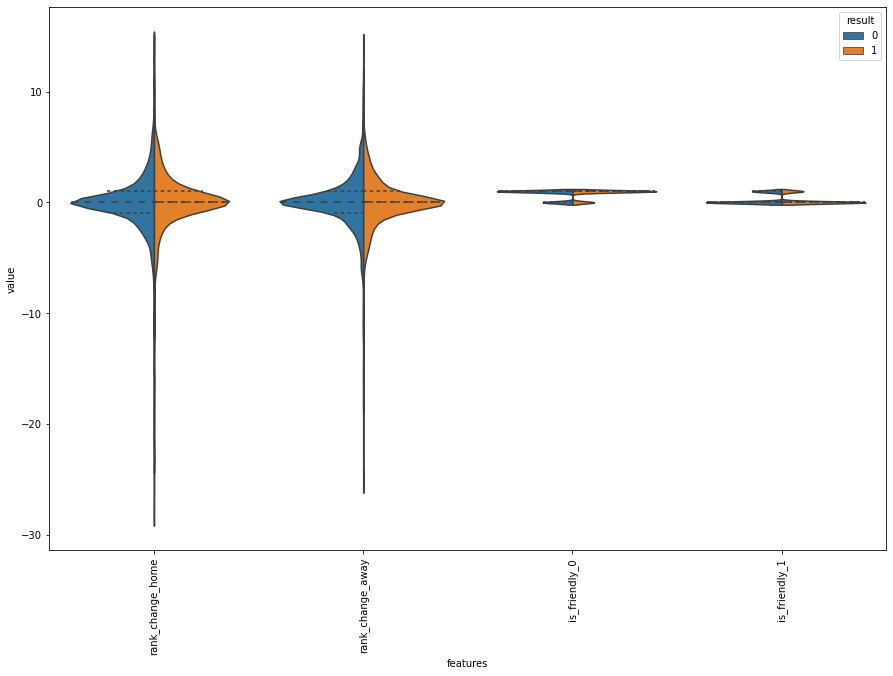

In [169]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="result", data=data_basics,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

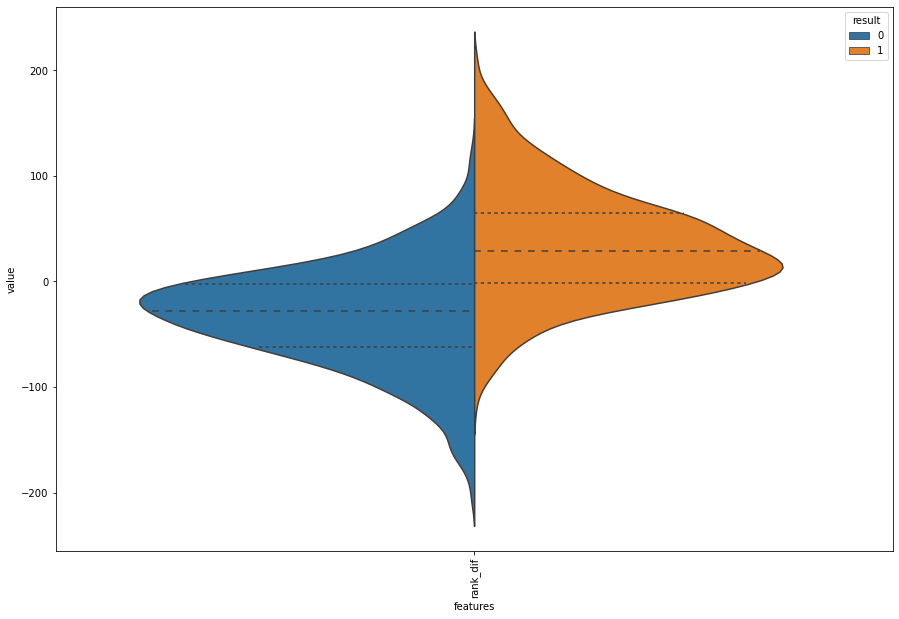

In [170]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="result", data=data_rank_dif,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

Nas figuras abaixo para quantidade de gols do time da casa e do time visitante, é possível perceber que as variáveis que consideram apenas os últimos 5, 10 e 15 jogos são muito parecidas, assim como as variáveis que consideram todos os jogos do ciclo da copa e a os últimos 30 jogos da seleção. No entanto, a diferença entre as distribuições dos resultados não é clara.

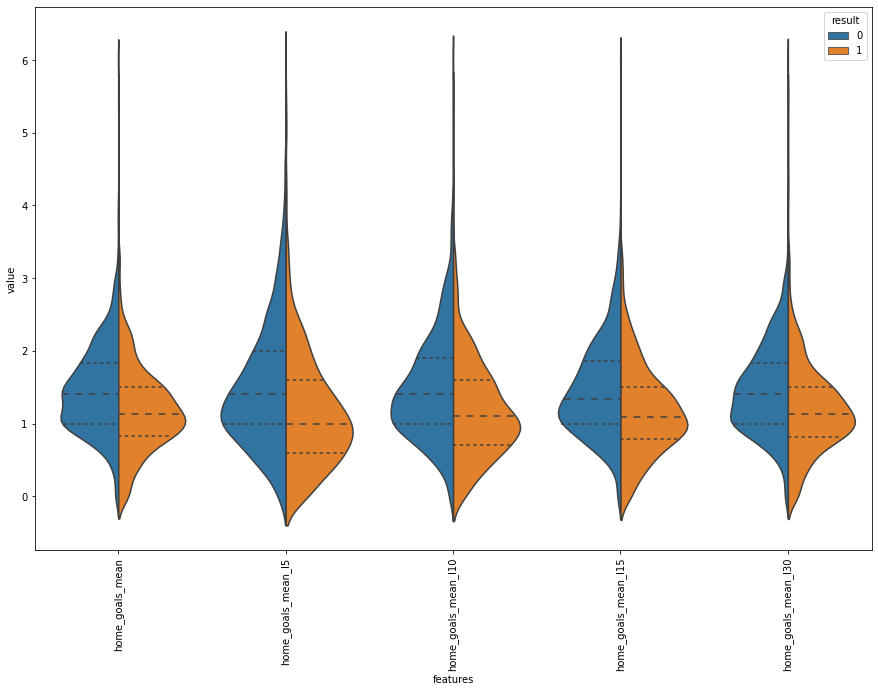

In [171]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="result", data=data_home_goals,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

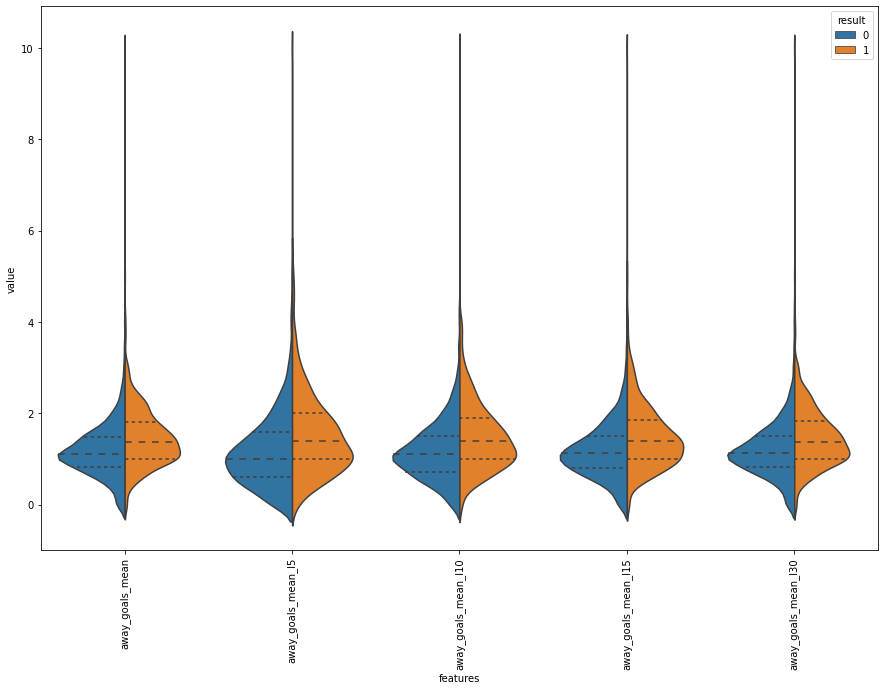

In [172]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="result", data=data_away_goals,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

Para os gols sofridos o padrão se mantém, com apenas podendo verificar mais diferenças entre gols nos últimos 5 jogos e no ciclo inteiro.

Nota-se que assim como o gráfico anterior e ao contrário do covariável de diferença de ranking, as médias são estatisticamente "iguais", pois estão dentro do intervalo de confiança para ambas os resultados.

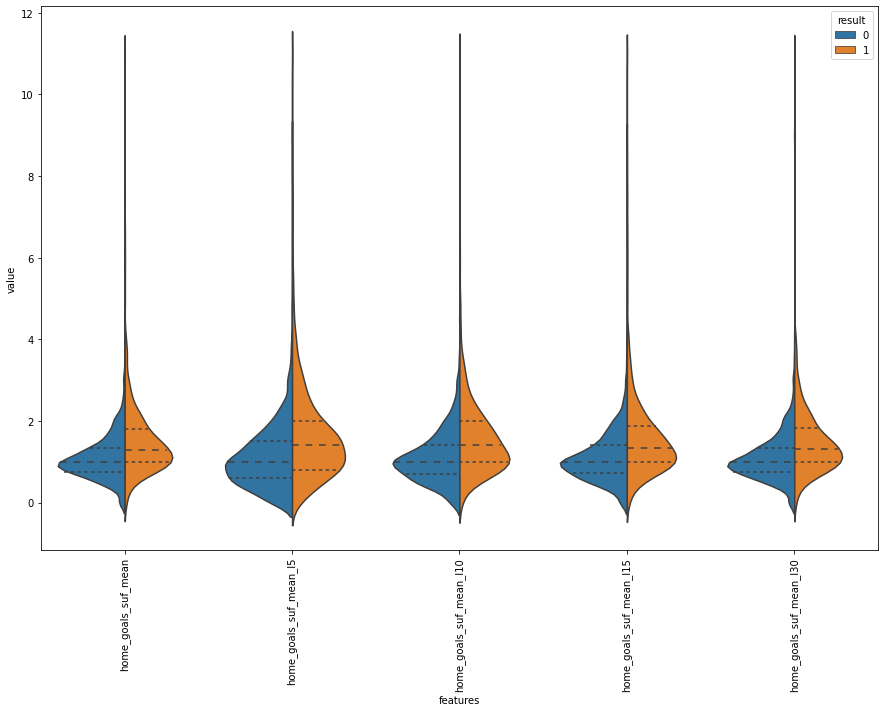

In [173]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="result", data=data_home_suf_goals,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

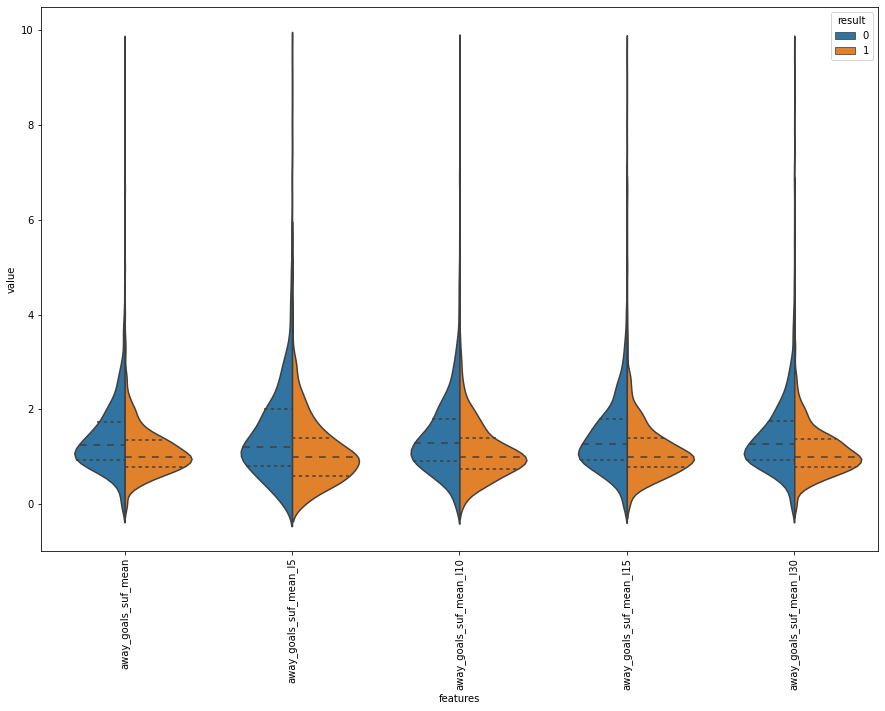

In [174]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="result", data=data_away_suf_goals,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

Analisando o ranking das seleções na FIFA, esse padrão fica ainda mais destacado, mostrando que provavelmente a melhor ideia seria ter uma variável para analisar o momento (últimos 5 jogos) e outra para avaliar a constância (ciclo inteiro).

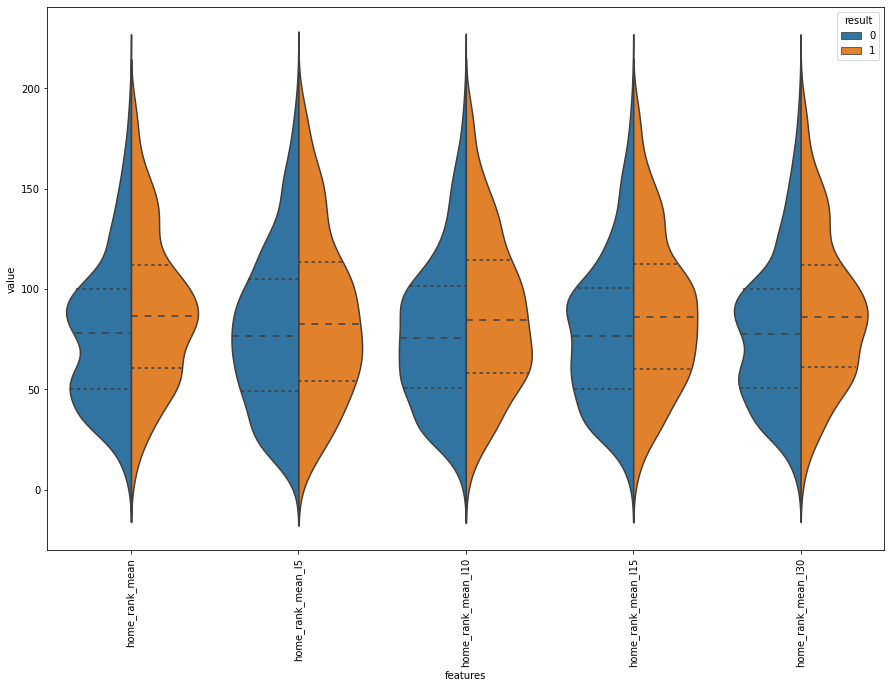

In [175]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="result", data=data_home_rank,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

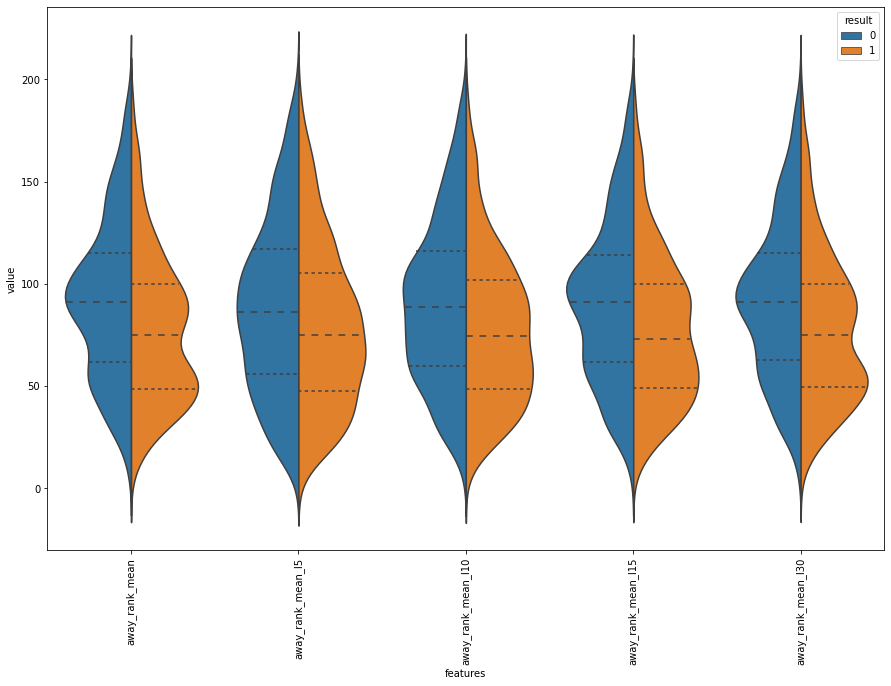

In [176]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="result", data=data_away_rank,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

Para a média dos pontos esse padrão tem uma pequena distorção, mas é como se fosse uma evolução saindo dos últimos 5 jogos até chegar nos últimos 30. 

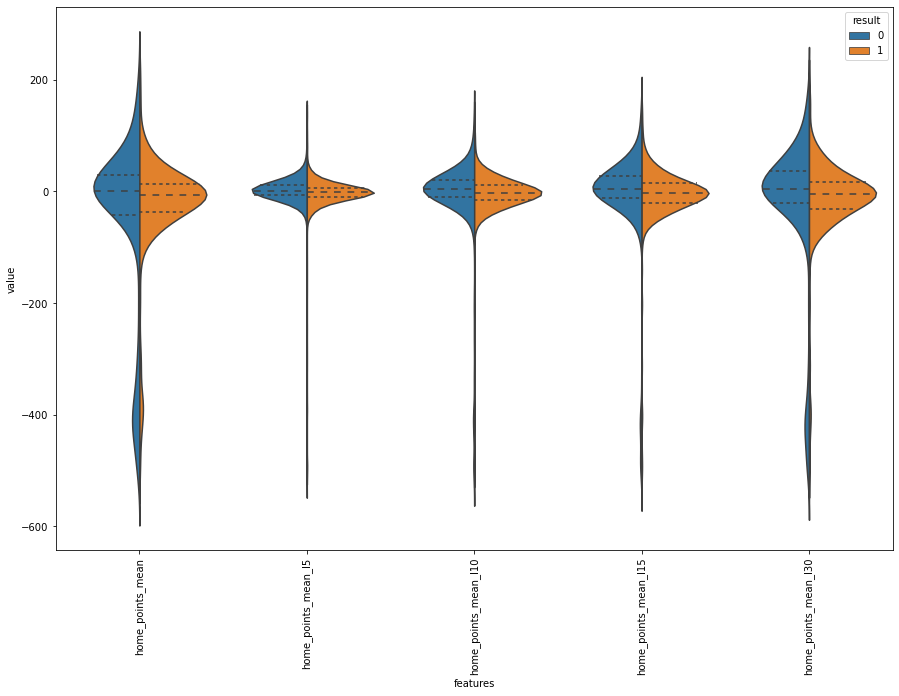

In [177]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="result", data=data_home_points,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

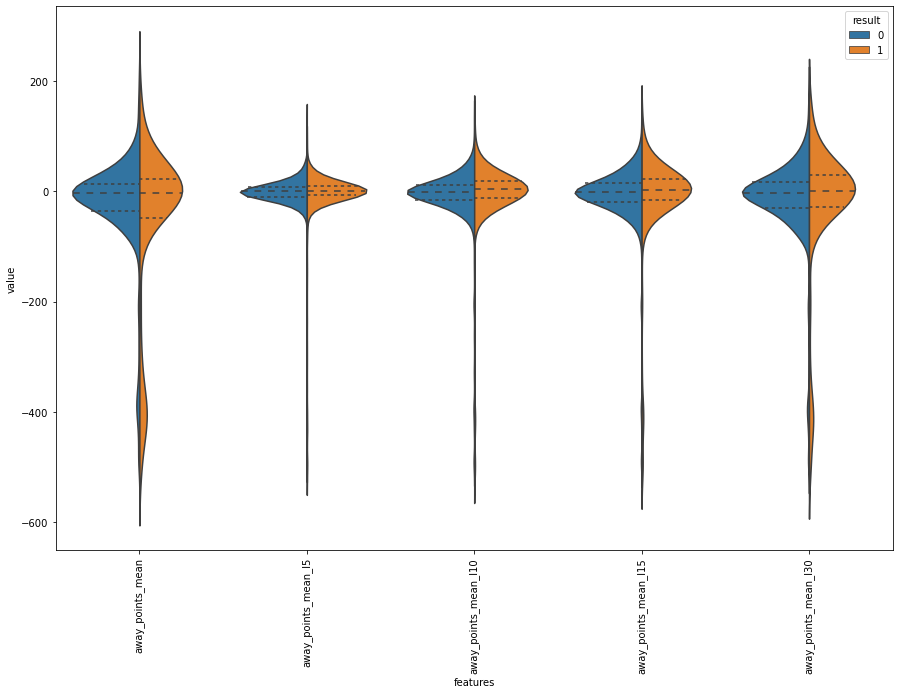

In [178]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="result", data=data_away_points,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

Nos pontos por ranking é perceptível apenas que todas as covariáveis são muito semelhantes.

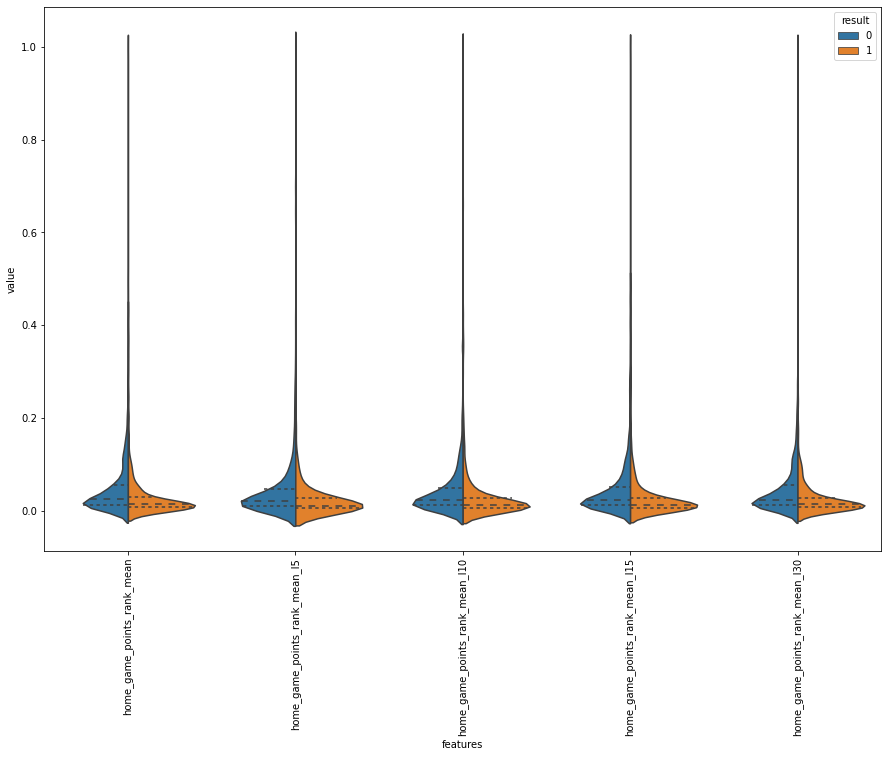

In [179]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="result", data=data_home_game_points_rank,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

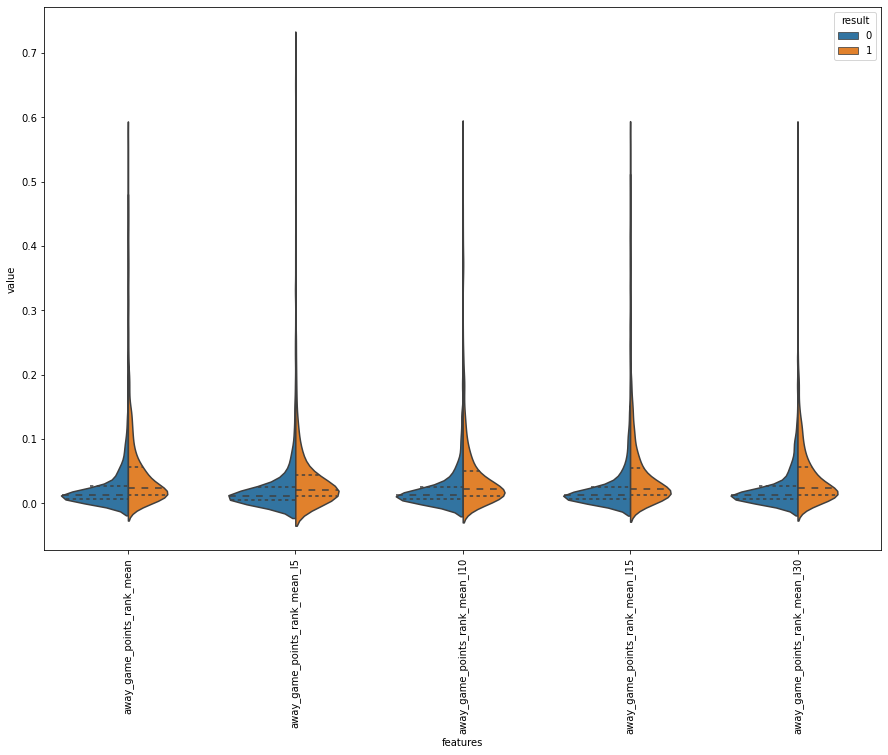

In [180]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="result", data=data_away_game_points_rank,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

Na variável ranking por classificação as 5 covariáveis são muito semelhantes, mas também nota-se uma maior aproximação dos últimos 5 jogos para os 10 e 15, que para as outras duas.

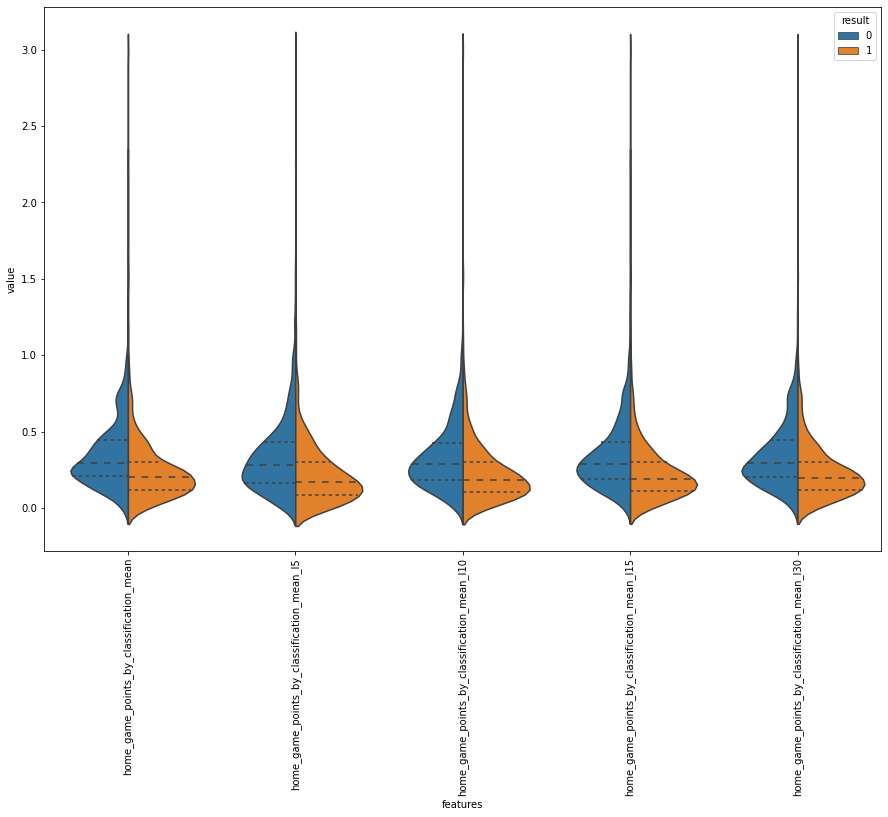

In [181]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="result", data=data_home_game_points_classification,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

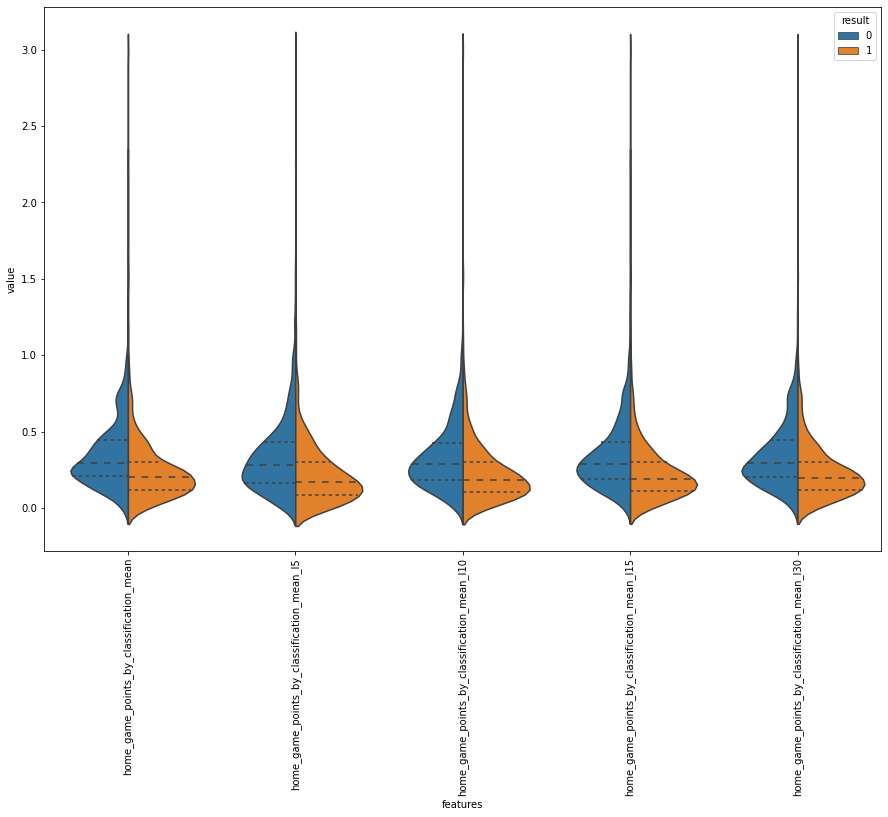

In [182]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="result", data=data_home_game_points_classification,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

Com os gráfico acima é perceptível, que a diferença de ranking entre as seleções é o único bom separador dos resultados. No entanto, vamos criar novas variáveis para que tenhamos outras variáveis boas para captar a difenreça entre o time visitante e o time da casa.

Descartarei os dados sobre os últimos 10 e 30 jogos, por se assemelharem muito aos dados sobre os últimos 5 e todo o ciclo, respectivamente.

## Reformulando a base de dados
Para ter menos NAS

In [183]:
stats_val = []

for index, row in team_stats.iterrows():
    team = row["team"]
    date = row["date"]
    past_games = team_stats.query("team == @team & date < @date").sort_values(by=['date'], ascending=False)
    last5 = past_games.head(5)
    last15 = past_games.head(15)

    
    goals = past_games["score"].mean()
    goals_l5 = last5["score"].mean()
    goals_l15 = last15["score"].mean()

    goals_suf = past_games["suf_score"].mean()
    goals_suf_l5 = last5["suf_score"].mean()
    goals_suf_l15 = last15["suf_score"].mean()
    
    rank = past_games["rank_suf"].mean()
    rank_l5 = last5["rank_suf"].mean()
    rank_l15 = last15["rank_suf"].mean()
    
    if len(last5) > 0:
        points = past_games["total_points"].values[0] - past_games["total_points"].values[-1]#qtd de pontos ganhos
        points_l5 = last5["total_points"].values[0] - last5["total_points"].values[-1] 
        points_l15 = last15["total_points"].values[0] - last15["total_points"].values[-1]
    else:
        points = 0
        points_l5 = 0
        points_l15 = 0    
        
    gp = past_games["team_points"].mean()
    gp_l5 = last5["team_points"].mean()
    gp_l15 = last15["team_points"].mean()
    
    gp_rank = past_games["points_by_rank"].mean()
    gp_rank_l5 = last5["points_by_rank"].mean()
    gp_rank_l15 = last15["points_by_rank"].mean()
    
    cp_rank = past_games["points_by_classification"].mean()
    cp_rank_l5 = last5["points_by_classification"].mean()
    cp_rank_l15 = last15["points_by_classification"].mean()
    
    
    stats_val.append([goals, goals_l5, goals_suf, goals_suf_l5, rank, rank_l5, points, points_l5, gp, gp_l5, gp_rank, gp_rank_l5, cp_rank, cp_rank_l5,
                    goals_l15, goals_suf_l15, rank_l15, points_l15, gp_l15, gp_rank_l15, cp_rank_l15])

In [184]:
stats_cols = (["goals_mean", "goals_mean_l5", "goals_suf_mean", "goals_suf_mean_l5", "rank_mean", "rank_mean_l5", 
                "points_mean", "points_mean_l5", "game_points_mean", "game_points_mean_l5", "game_points_rank_mean", "game_points_rank_mean_l5",
                "game_points_by_classification_mean", "game_points_by_classification_mean_l5",
                "goals_mean_l15", "goals_suf_mean_l15", "rank_mean_l15", "points_mean_l15", "game_points_mean_l15", "game_points_rank_mean_l15",  
                "game_points_by_classification_mean_l15" 
                ])

stats_df = pd.DataFrame(stats_val, columns=stats_cols)

In [185]:
stats_df

,goals_mean,goals_mean_l5,goals_suf_mean,goals_suf_mean_l5,rank_mean,rank_mean_l5,points_mean,points_mean_l5,game_points_mean,game_points_mean_l5,...,game_points_rank_mean_l5,game_points_by_classification_mean,game_points_by_classification_mean_l5,goals_mean_l15,goals_suf_mean_l15,rank_mean_l15,points_mean_l15,game_points_mean_l15,game_points_rank_mean_l15,game_points_by_classification_mean_l15
0,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6725,1.800000,2.2,1.111111,1.0,54.533333,42.0,90.53,2.00,1.866667,2.0,...,0.073887,0.418519,0.433333,2.066667,0.866667,49.200000,36.63,2.133333,0.070955,0.502778
6726,1.380952,1.0,1.000000,1.8,76.357143,29.2,-19.52,-5.75,1.404762,1.0,...,0.029545,0.264087,0.250000,1.533333,1.266667,66.133333,2.60,1.400000,0.024263,0.235000
6727,0.767442,0.6,1.767442,1.4,70.418605,63.8,-99.48,-5.57,0.767442,1.0,...,0.019652,0.130620,0.216667,0.533333,2.066667,73.066667,-60.26,0.666667,0.009456,0.112222
6728,1.023256,1.2,1.279070,1.4,57.906977,95.6,-92.90,-24.45,1.139535,1.0,...,0.009470,0.214341,0.125000,1.066667,1.000000,74.533333,-26.64,1.266667,0.031528,0.233333


In [186]:
full_df = pd.concat([team_stats.reset_index(drop=True), stats_df], axis=1, ignore_index=False)

In [187]:
team_stats

,date,team,score,suf_score,rank,rank_suf,rank_change,total_points,result,rank_dif,points_by_rank,team_points,country_classification,points_by_classification
0,2018-07-01,Russia,1.0,1.0,49.0,6.0,-12.0,1758.00,2,43.0,0.166667,1,6,1.0
1,2018-07-01,Croatia,1.0,1.0,12.0,15.0,-6.0,2036.00,2,-3.0,0.066667,1,2,0.5
2,2018-07-02,Brazil,2.0,0.0,4.0,10.0,1.0,2160.00,0,-6.0,0.300000,3,1,1.5
3,2018-07-02,Belgium,3.0,2.0,5.0,41.0,-1.0,2124.00,0,-36.0,0.073171,3,1,0.75
4,2018-07-03,Sweden,1.0,0.0,21.0,8.0,-1.0,1955.00,0,13.0,0.375000,3,4,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3360,2022-09-27,Serbia,2.0,0.0,25.0,36.0,0.0,1549.53,1,11.0,0.083333,3,4,0.75
3361,2022-09-27,Slovenia,1.0,1.0,65.0,20.0,0.0,1372.48,2,-45.0,0.050000,1,6,0.25
3362,2022-09-27,Cyprus,1.0,5.0,108.0,106.0,1.0,1180.52,0,-2.0,0.000000,0,8,0.0
3363,2022-09-27,Northern Ireland,1.0,3.0,58.0,49.0,0.0,1399.10,0,-9.0,0.000000,0,6,0.0


In [188]:
home_team_stats = full_df.iloc[:int(full_df.shape[0]/2),:]
away_team_stats = full_df.iloc[int(full_df.shape[0]/2):,:]

In [189]:
home_team_stats.columns[-21:]

Index(['goals_mean', 'goals_mean_l5', 'goals_suf_mean', 'goals_suf_mean_l5',
       'rank_mean', 'rank_mean_l5', 'points_mean', 'points_mean_l5',
       'game_points_mean', 'game_points_mean_l5', 'game_points_rank_mean',
       'game_points_rank_mean_l5', 'game_points_by_classification_mean',
       'game_points_by_classification_mean_l5', 'goals_mean_l15',
       'goals_suf_mean_l15', 'rank_mean_l15', 'points_mean_l15',
       'game_points_mean_l15', 'game_points_rank_mean_l15',
       'game_points_by_classification_mean_l15'],
      dtype='object')

In [190]:
home_team_stats = home_team_stats[home_team_stats.columns[-21:]]
away_team_stats = away_team_stats[away_team_stats.columns[-21:]]

In [191]:
home_team_stats.columns = ['home_'+str(col) for col in home_team_stats.columns]
away_team_stats.columns = ['away_'+str(col) for col in away_team_stats.columns]

In [192]:
match_stats = pd.concat([home_team_stats, away_team_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [196]:
full_df = pd.concat([df, match_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [198]:
full_df['tournament']

8       FIFA World Cup
9       FIFA World Cup
11      FIFA World Cup
12      FIFA World Cup
13      FIFA World Cup
             ...      
3350               NaN
3351               NaN
3358               NaN
3359               NaN
3361               NaN
Name: tournament, Length: 3365, dtype: object

In [199]:
def find_friendly(x):
    if x == "Friendly":
        return 1
    else: return 0

full_df["is_friendly"] = full_df["tournament"].apply(lambda x: find_friendly(x)) 

In [200]:
full_df = pd.get_dummies(full_df, columns=["is_friendly"])

In [ ]:
base_df = full_df[["date", "home_team", "away_team", "rank_home", "rank_away","home_score", "away_score","result", "rank_dif", "rank_change_home", "rank_change_away", 'home_goals_mean',
        'country_classification_home', 'country_classification_away',
       'home_goals_mean_l5', 'home_goals_suf_mean', 'home_goals_suf_mean_l5',
       'home_rank_mean', 'home_rank_mean_l5', 'home_points_mean',
       'home_points_mean_l5', 'away_goals_mean', 'away_goals_mean_l5',
       'away_goals_suf_mean', 'away_goals_suf_mean_l5', 'away_rank_mean',
       'away_rank_mean_l5', 'away_points_mean', 'away_points_mean_l5','home_game_points_mean', 'home_game_points_mean_l5',
       'home_game_points_rank_mean', 'home_game_points_rank_mean_l5', 'home_game_points_by_classification_mean',
       'home_game_points_by_classification_mean_l5',
       'away_game_points_mean',
       'away_game_points_mean_l5', 'away_game_points_rank_mean',
       'away_game_points_rank_mean_l5', 'away_game_points_by_classification_mean',
       'away_game_points_by_classification_mean_l5',
       'is_friendly_0', 'is_friendly_1',
       'home_goals_mean_l15', 
       'home_goals_suf_mean_l15', 'home_rank_mean_l15', 'home_points_mean_l15',
        'home_game_points_mean_l15',
       'home_game_points_rank_mean_l15', 
       'home_game_points_by_classification_mean_l15',
       'away_goals_mean_l15', 'away_goals_suf_mean_l15', 'away_rank_mean_l15', 
        'away_points_mean_l15', 'away_game_points_mean_l15',
       'away_game_points_rank_mean_l15', 
       'away_game_points_by_classification_mean_l15'
       ]]


In [201]:
base_df_no_fg = base_df.dropna()

In [202]:
df = base_df_no_fg

In [203]:
df = df.query("result != 2")

In [204]:
df.columns

Index(['date', 'home_team', 'away_team', 'rank_home', 'rank_away',
       'home_score', 'away_score', 'result', 'rank_dif', 'rank_change_home',
       'rank_change_away', 'home_goals_mean', 'tournament',
       'country_classification_home', 'country_classification_away',
       'home_goals_mean_l5', 'home_goals_suf_mean', 'home_goals_suf_mean_l5',
       'home_rank_mean', 'home_rank_mean_l5', 'home_points_mean',
       'home_points_mean_l5', 'away_goals_mean', 'away_goals_mean_l5',
       'away_goals_suf_mean', 'away_goals_suf_mean_l5', 'away_rank_mean',
       'away_rank_mean_l5', 'away_points_mean', 'away_points_mean_l5',
       'home_game_points_mean', 'home_game_points_mean_l5',
       'home_game_points_rank_mean', 'home_game_points_rank_mean_l5',
       'home_game_points_by_classification_mean',
       'home_game_points_by_classification_mean_l5', 'away_game_points_mean',
       'away_game_points_mean_l5', 'away_game_points_rank_mean',
       'away_game_points_rank_mean_l5',
    

In [205]:
dif = df.copy()
dif.loc[:, "goals_dif"] = dif["home_goals_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_mean_l5"]
dif.loc[:, "goals_dif_l15"] = dif["home_goals_mean_l15"] - dif["away_goals_mean_l15"]
dif.loc[:, "goals_suf_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_suf_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_suf_dif_l15"] = dif["home_goals_suf_mean_l15"] - dif["away_goals_suf_mean_l15"]
dif.loc[:, "goals_made_suf_dif"] = dif["home_goals_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_made_suf_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_made_suf_dif_l15"] = dif["home_goals_mean_l15"] - dif["away_goals_suf_mean_l15"]
dif.loc[:, "goals_suf_made_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_suf_made_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_mean_l5"]
dif.loc[:, "goals_suf_made_dif_l15"] = dif["home_goals_suf_mean_l15"] - dif["away_goals_mean_l15"]

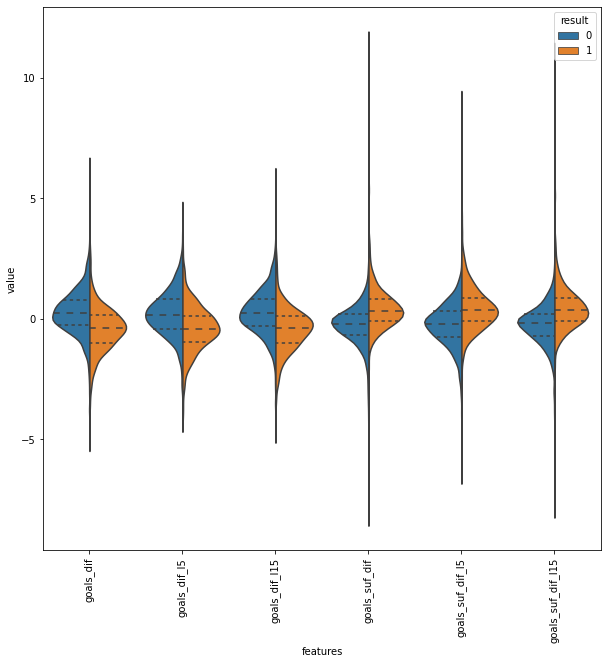

In [207]:
data_difs = dif.iloc[:, -12:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["result"] = dif["result"]
violin = pd.melt(scaled,id_vars="result", var_name="features", value_name="value")

plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="result", data=violin.iloc[:int(len(violin)/2), :],split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

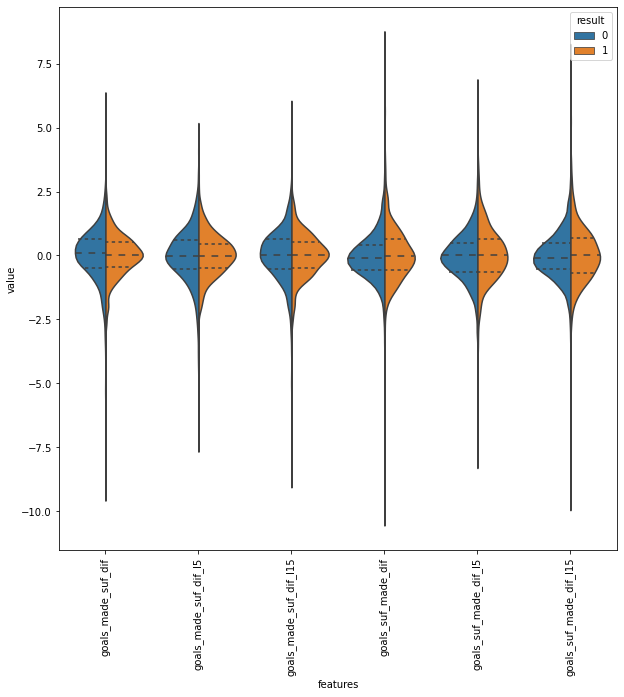

In [208]:
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="result", data=violin.iloc[int(len(violin)/2):, :],split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

Com a Figura 1 podemos notar mais variáveis com diferenças, como: goals_dif e goals_suf_dif, ainda não extremamente significante quanto rank_dif.

No entanto, a diferença entre gols feitos e sofridos ou o inverso, tem distribuições extremamente parecidas.

Assim, nós temos 7 covariáveis:
- rank_dif
- goals_dif
- goals_dif_l5
- goals_dif_l15
- goals_suf_dif
- goals_suf_dif_l5
- goals_suf_dif_l15

Nós podemos criar novas variáveis baseadas nos pontos feitos, nos pontos feitos por ranking e classificação.

In [209]:
dif.shape

(2476, 98)

In [210]:
dif.loc[:, "dif_classification_rank"] = dif["home_game_points_by_classification_mean"] - dif["away_game_points_by_classification_mean"]
dif.loc[:, "dif_classification_rank_l5"] = dif["home_game_points_by_classification_mean_l5"] - dif["away_game_points_by_classification_mean_l5"]
dif.loc[:, "dif_classification_rank_l15"] = dif["home_game_points_by_classification_mean_l15"] - dif["away_game_points_by_classification_mean_l15"]
dif.loc[:, "dif_rank_agst"] = dif["home_rank_mean"] - dif["away_rank_mean"]
dif.loc[:, "dif_rank_agst_l5"] = dif["home_rank_mean_l5"] - dif["away_rank_mean_l5"]
dif.loc[:, "dif_rank_agst_l15"] = dif["home_rank_mean_l15"] - dif["away_rank_mean_l15"]

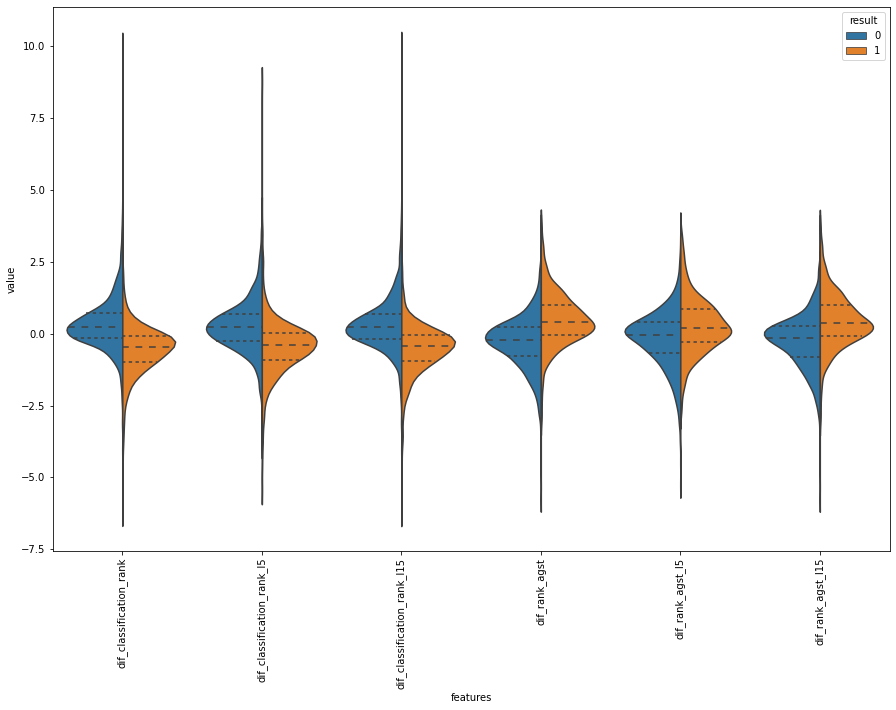

In [211]:
data_difs = dif.iloc[:, -6:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["result"] = df["result"]
violin = pd.melt(scaled,id_vars="result", var_name="features", value_name="value")

plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="result", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

As variáveis tem comportamento muito semelhantes, apesar do recorte de tempo diferente. 

No entanto, a variável resposta (resultado) tem distribuição com uma boa diferença. 

In [212]:
dif.loc[:, "dif_points"] = dif["home_game_points_mean"] - dif["away_game_points_mean"]
dif.loc[:, "dif_points_l5"] = dif["home_game_points_mean_l5"] - dif["away_game_points_mean_l5"]
dif.loc[:, "dif_points_l15"] = dif["home_game_points_mean_l15"] - dif["away_game_points_mean_l15"]
dif.loc[:, "dif_points_rank"] = dif["home_game_points_rank_mean"] - dif["away_game_points_rank_mean"]
dif.loc[:, "dif_points_rank_l5"] = dif["home_game_points_rank_mean_l5"] - dif["away_game_points_rank_mean_l5"]
dif.loc[:, "dif_points_rank_l15"] = dif["home_game_points_rank_mean_l15"] - dif["away_game_points_rank_mean_l15"]

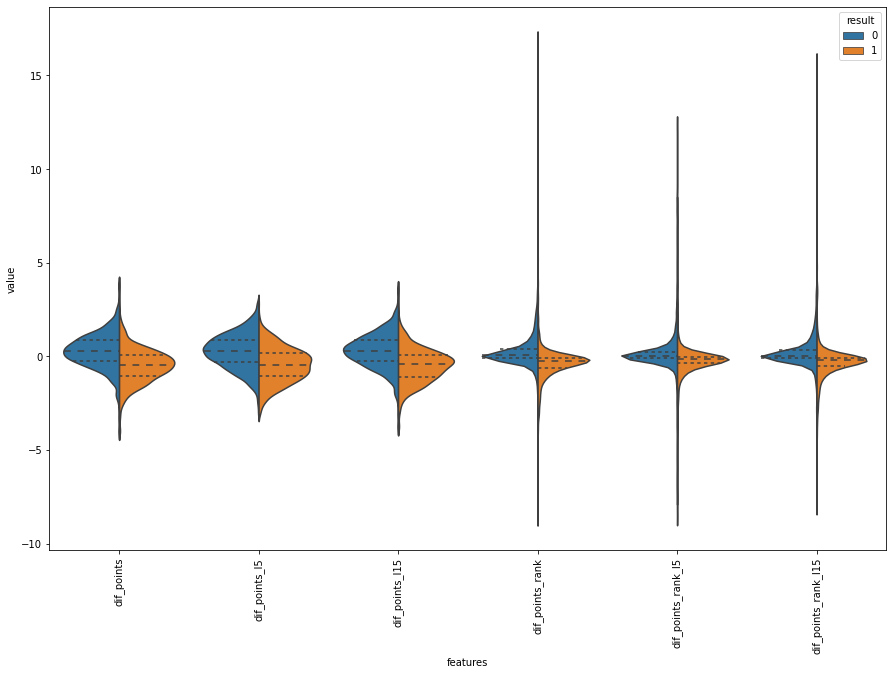

In [213]:
data_difs = dif.iloc[:, -6:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["result"] = df["result"]
violin = pd.melt(scaled,id_vars="result", var_name="features", value_name="value")

plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="result", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

Assim como no exemplo anterior as variáveis tem distribuição parecida, no entanto, o resultado tem distribuição razoavelmente diferente.

Também é possível analisarmos gols feitos e sofridos por ranking e verificar a diferença.

In [214]:
dif.loc[:, "goals_per_ranking_dif"] = (dif["home_goals_mean"] / dif["home_rank_mean"]) - (dif["away_goals_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif"] = (dif["home_goals_suf_mean"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_dif_l5"] = (dif["home_goals_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_mean_l5"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif_l5"] = (dif["home_goals_suf_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean_l5"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_dif_l15"] = (dif["home_goals_mean_l15"] / dif["home_rank_mean"]) - (dif["away_goals_mean_l15"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif_l15"] = (dif["home_goals_suf_mean_l15"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean_l15"] / dif["away_rank_mean"])

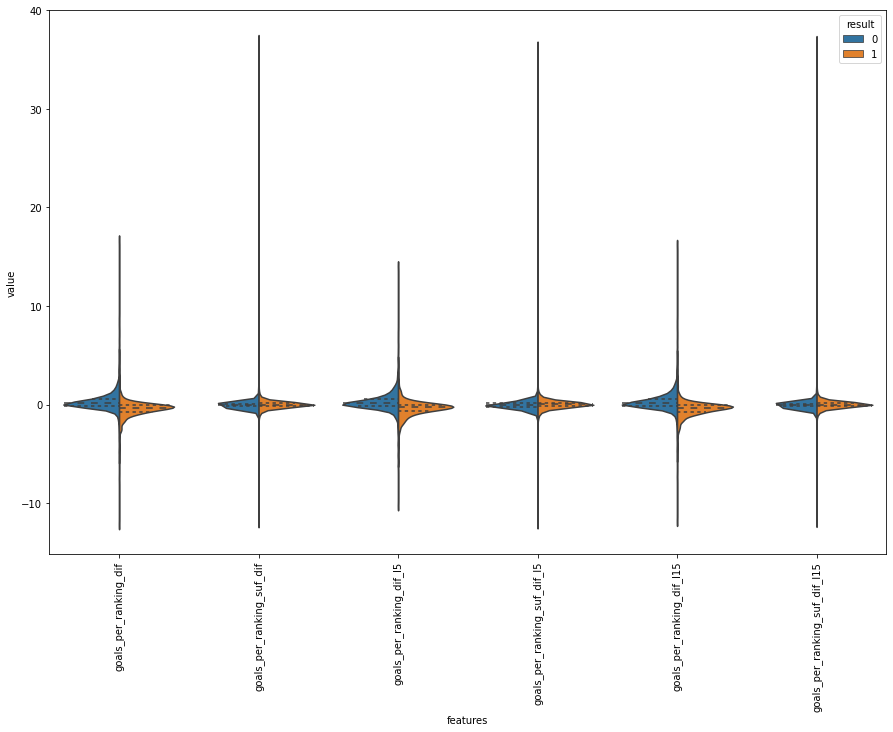

In [215]:
data_difs = dif.iloc[:, -6:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["result"] = df["result"]
violin = pd.melt(scaled,id_vars="result", var_name="features", value_name="value")

plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="result", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

Como os valores são pequenos, o violin plot não consegue demonstrar a diferença de maneira efetiva visualmente, assim vamos utilizar o boxplot:

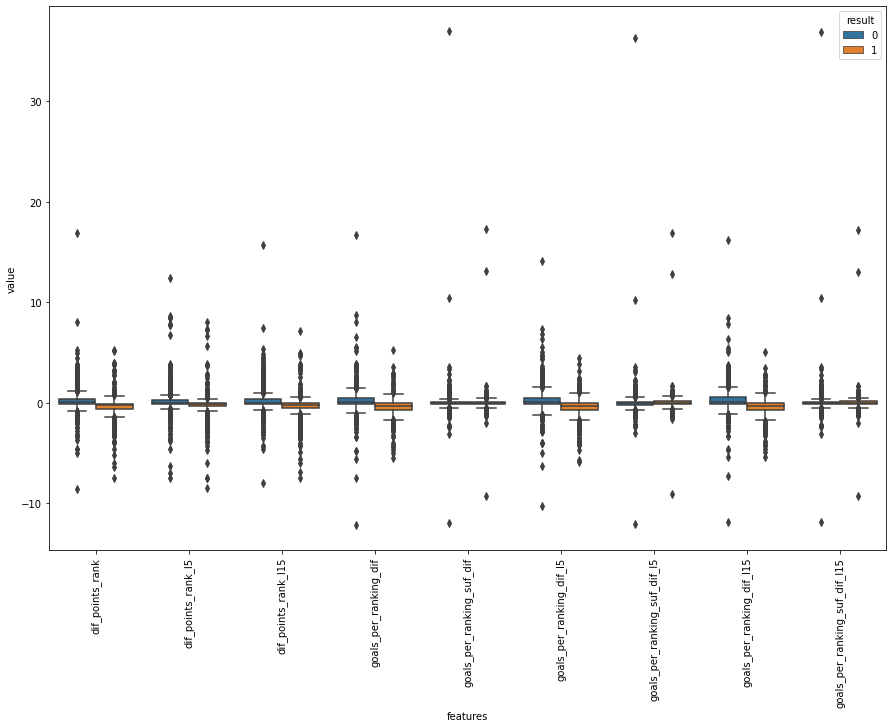

In [216]:
data_difs = dif.iloc[:, -9:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["result"] = df["result"]
violin = pd.melt(scaled,id_vars="result", var_name="features", value_name="value")

plt.figure(figsize=(15,10))
sns.boxplot(x="features", y="value", hue="result", data=violin)
plt.xticks(rotation=90)
plt.show()

Diferença de pontos, diferença de pontos por ranking dos adversários, diferença de classificação e diferença de ranking enfrentado.  Considerando todo o ciclo, últimos 5 jogos e últimos 15. Agora vamos utilizar gráficos de pontos para verificar suas distribuições.

In [217]:
data_difs = dif.iloc[:, -24:]

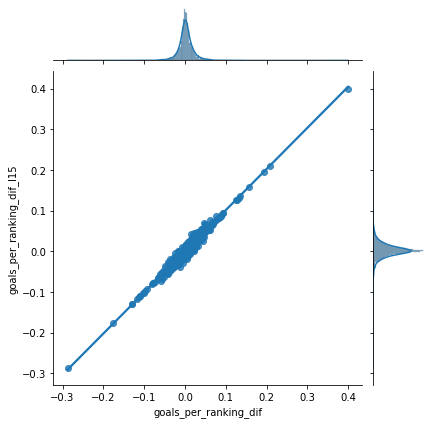

In [218]:
sns.jointplot(data = data_difs, x = 'goals_per_ranking_dif', y = 'goals_per_ranking_dif_l15', kind="reg")
plt.show()

Diferença de gols pelo ranking do adversário tanto no ciclo inteiro, últimos 5 jogos ou últimos 15 tem distribuições similares. Então vamos utilizar apenas o do ciclo inteiro.

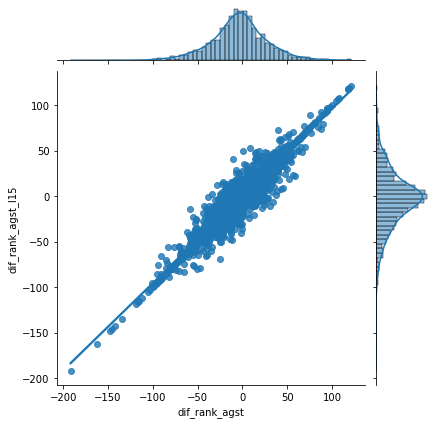

In [219]:
sns.jointplot(data = data_difs, x = 'dif_rank_agst', y = 'dif_rank_agst_l15', kind="reg")
plt.show()

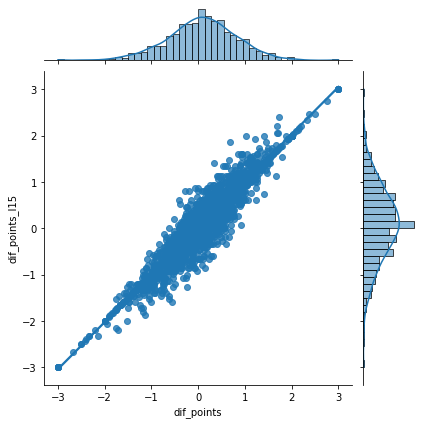

In [220]:
sns.jointplot(data = data_difs, x = 'dif_points', y = 'dif_points_l15', kind="reg")
plt.show()

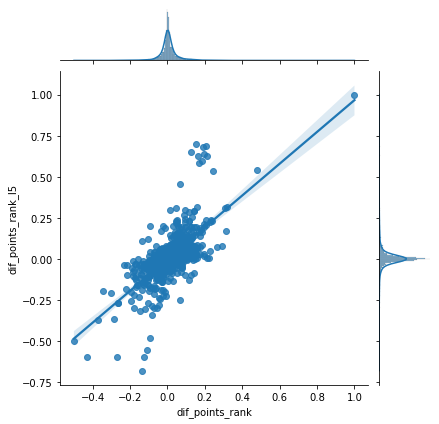

In [221]:
sns.jointplot(data = data_difs, x = 'dif_points_rank', y = 'dif_points_rank_l5', kind="reg")
plt.show()

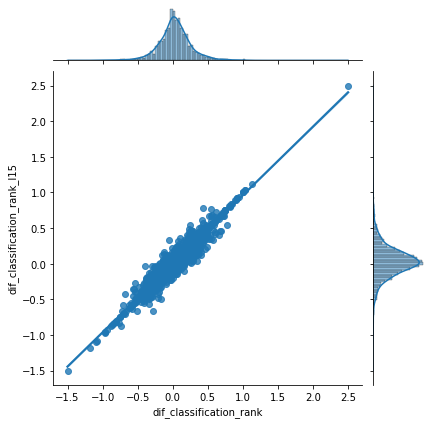

In [222]:
sns.jointplot(data = data_difs, x = 'dif_classification_rank', y = 'dif_classification_rank_l15', kind="reg")
plt.show()

Assim como em diferença de gols pelo ranking do adversário tanto no ciclo inteiro, a diferença da classificação do ranking nos últimos 5 jogos ou últimos 15 tem distribuições similares. Então vamos utilizar apenas o do ciclo inteiro.

Para a diferença de ranking do adversário enfrentando, pontos pelo ranking do adversário enfrentando e média de pontos conquistada pela média de pontos do ranking enfrentando, as 3 versões (ciclo, 5 e 15 últimos jogos) não são similares. Então, vamos usar todos:

Assim, as covariáveis finais ficam:

- rank_dif
- goals_dif
- goals_dif_l5
- goals_suf_dif
- goals_suf_dif_l5
- dif_rank_agst
- dif_rank_agst_l5
- goals_per_ranking_dif
- dif_points_rank
- dif_points_rank_l5
- is_friendly

In [421]:
def create_db(df):
    columns = ["home_team", "away_team", "result", "rank_dif", "home_goals_mean", "home_rank_mean", "away_goals_mean", 
                "away_rank_mean", "home_rank_mean_l5", "away_rank_mean_l5", "home_goals_suf_mean", "away_goals_suf_mean", 
                "home_goals_mean_l5", "away_goals_mean_l5", "home_goals_suf_mean_l5", "away_goals_suf_mean_l5", 
                "home_game_points_rank_mean", "home_game_points_rank_mean_l5", "away_game_points_rank_mean", "away_game_points_rank_mean_l5",
                "is_friendly_0", "is_friendly_1", 
                "home_game_points_by_classification_mean", "away_game_points_by_classification_mean",
                "home_game_points_by_classification_mean_l5", "away_game_points_by_classification_mean_l5"]
    
    base = df.loc[:, columns]
    base.loc[:, "goals_dif"] = base["home_goals_mean"] - base["away_goals_mean"]
    base.loc[:, "goals_dif_l5"] = base["home_goals_mean_l5"] - base["away_goals_mean_l5"]
    base.loc[:, "goals_suf_dif"] = base["home_goals_suf_mean"] - base["away_goals_suf_mean"]
    base.loc[:, "goals_suf_dif_l5"] = base["home_goals_suf_mean_l5"] - base["away_goals_suf_mean_l5"]
    base.loc[:, "goals_per_ranking_dif"] = (base["home_goals_mean"] / base["home_rank_mean"]) - (base["away_goals_mean"] / base["away_rank_mean"])
    base.loc[:, "dif_rank_agst"] = base["home_rank_mean"] - base["away_rank_mean"]
    base.loc[:, "dif_rank_agst_l5"] = base["home_rank_mean_l5"] - base["away_rank_mean_l5"]
    base.loc[:, "dif_points_rank"] = base["home_game_points_rank_mean"] - base["away_game_points_rank_mean"]
    base.loc[:, "dif_points_rank_l5"] = base["home_game_points_rank_mean_l5"] - base["away_game_points_rank_mean_l5"]
    base.loc[:, "dif_points_by_classification"] =  base["home_game_points_by_classification_mean"] - base["away_game_points_by_classification_mean"]
    
    model_df = base[["home_team", "away_team", "result", "rank_dif", 
                    "goals_dif", "goals_dif_l5", "goals_suf_dif", "goals_suf_dif_l5", "goals_per_ranking_dif", 
                    "dif_rank_agst", "dif_rank_agst_l5", "dif_points_rank", "dif_points_rank_l5", 
                    "is_friendly_0", "is_friendly_1",
                    "dif_points_by_classification"]]
    return model_df

# Onde era target coloquei result

In [233]:
def create_db2(df):
    columns = ["home_team", "away_team", "result", "rank_dif", "home_goals_mean", "home_rank_mean", "away_goals_mean", 
                "away_rank_mean", "home_rank_mean_l5", "away_rank_mean_l5", "home_goals_suf_mean", "away_goals_suf_mean", 
                "home_goals_mean_l5", "away_goals_mean_l5", "home_goals_suf_mean_l5", "away_goals_suf_mean_l5", 
                "home_game_points_rank_mean", "home_game_points_rank_mean_l5", "away_game_points_rank_mean", "away_game_points_rank_mean_l5",
                "is_friendly_0", "is_friendly_1", 
                "home_game_points_by_classification_mean", "away_game_points_by_classification_mean",
                "home_game_points_by_classification_mean_l5", "away_game_points_by_classification_mean_l5", 
                "home_goals_mean_l15", "away_goals_mean_l15", "home_goals_suf_mean_l15", "away_goals_suf_mean_l15",
                "home_rank_mean_l15", "away_rank_mean_l15", "home_game_points_rank_mean_l15",
                "away_game_points_rank_mean_l15", 
                ]

    
    base = df.loc[:, columns]
    base.loc[:, "goals_dif"] = base["home_goals_mean"] - base["away_goals_mean"]
    base.loc[:, "goals_dif_l5"] = base["home_goals_mean_l5"] - base["away_goals_mean_l5"]
    base.loc[:, "goals_suf_dif"] = base["home_goals_suf_mean"] - base["away_goals_suf_mean"]
    base.loc[:, "goals_suf_dif_l5"] = base["home_goals_suf_mean_l5"] - base["away_goals_suf_mean_l5"]
    base.loc[:, "goals_per_ranking_dif"] = (base["home_goals_mean"] / base["home_rank_mean"]) - (base["away_goals_mean"] / base["away_rank_mean"])
    base.loc[:, "dif_rank_agst"] = base["home_rank_mean"] - base["away_rank_mean"]
    base.loc[:, "dif_rank_agst_l5"] = base["home_rank_mean_l5"] - base["away_rank_mean_l5"]
    base.loc[:, "dif_rank_agst_l15"] = base["home_rank_mean_l15"] - base["away_rank_mean_l15"]
    base.loc[:, "dif_points_rank"] = base["home_game_points_rank_mean"] - base["away_game_points_rank_mean"]
    base.loc[:, "dif_points_rank_l5"] = base["home_game_points_rank_mean_l5"] - base["away_game_points_rank_mean_l5"]
    base.loc[:, "dif_points_rank_l15"] = base["home_game_points_rank_mean_l15"] - base["away_game_points_rank_mean_l15"]

    base.loc[:, "dif_points_by_classification"] =  base["home_game_points_by_classification_mean"] - base["away_game_points_by_classification_mean"]
    
    model_df = base[["home_team", "away_team", "result", "rank_dif", 
                    "goals_dif", "goals_dif_l5", "goals_suf_dif", "goals_suf_dif_l5", "goals_per_ranking_dif", 
                    "dif_rank_agst", "dif_rank_agst_l5", "dif_points_rank", "dif_points_rank_l5", 
                    "is_friendly_0", "is_friendly_1", 
                    "dif_rank_agst_l15", "dif_points_rank_l15", 
                    "dif_points_by_classification"]]
    return model_df


In [422]:
model_db = create_db(df)

In [234]:
model_db2 = create_db2(df)

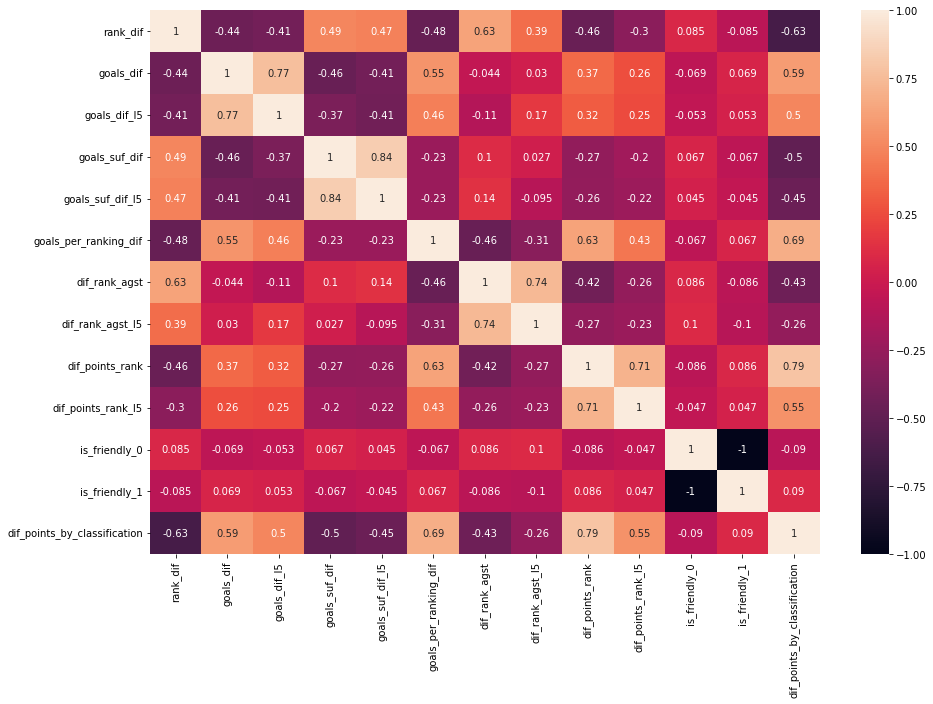

In [227]:
plt.figure(figsize=(15, 10))
sns.heatmap(model_db.iloc[:,3:].corr(), annot=True)
plt.show()

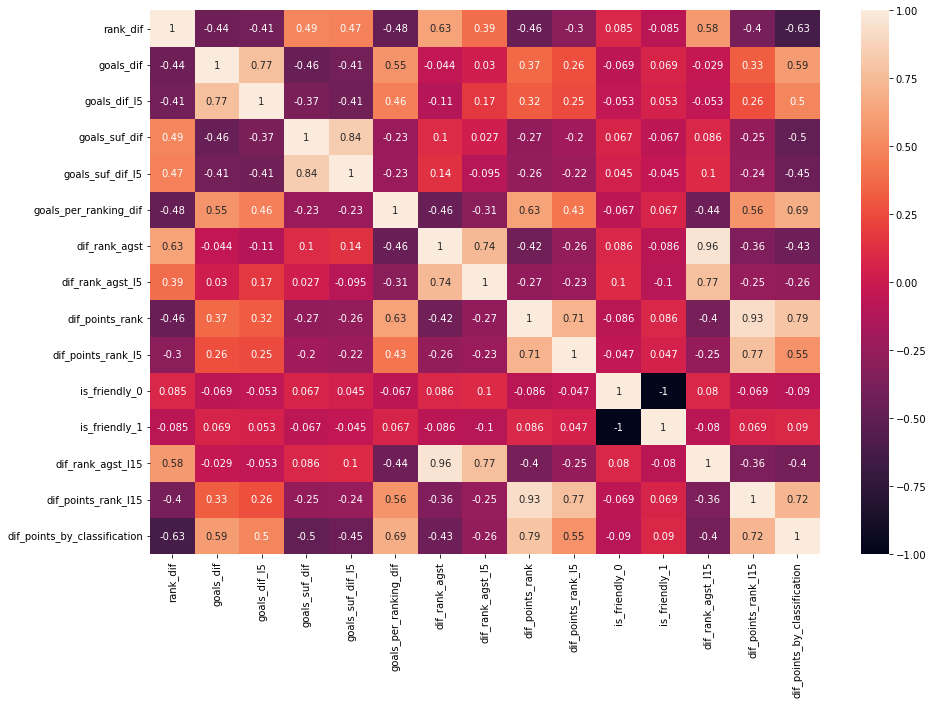

In [235]:
plt.figure(figsize=(15, 10))
sns.heatmap(model_db2.iloc[:,3:].corr(), annot=True)
plt.show()

# The model

Now that we have a database ready and with columns with predictive power, we can start our modelling. 

Two models will be tested: Random Forest and Gradient Boosting. The selected will be the one with best recall.

In [423]:
model_db

,home_team,away_team,result,rank_dif,goals_dif,goals_dif_l5,goals_suf_dif,goals_suf_dif_l5,goals_per_ranking_dif,dif_rank_agst,dif_rank_agst_l5,dif_points_rank,dif_points_rank_l5,is_friendly_0,is_friendly_1,dif_points_by_classification,dif_points_by_classification_l5
8,Brazil,Belgium,1,-1.0,-1.000000,-1.000000,-2.000000,-2.000000,0.126829,-31.000000,-31.0,0.226829,0.226829,1,0,0.750000,0.750000
9,Sweden,England,1,14.0,0.000000,0.000000,-1.000000,-1.000000,0.066176,-9.000000,-9.0,0.316176,0.316176,1,0,2.500000,2.500000
11,France,Belgium,0,-3.0,-0.500000,-0.500000,-1.500000,-1.500000,0.031746,-8.500000,-8.5,-0.197300,-0.197300,1,0,-0.375000,-0.375000
12,Croatia,England,0,5.0,0.000000,0.000000,1.000000,1.000000,-0.032072,13.000000,13.0,-0.057303,-0.057303,1,0,-0.291667,-0.291667
13,Belgium,England,0,-2.0,0.333333,0.333333,0.333333,0.333333,0.026383,-1.000000,-1.0,0.207163,0.207163,1,0,0.833333,0.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3357,Republic of Ireland,Armenia,0,-45.0,-0.181872,0.600000,-1.293381,-1.800000,0.002826,-21.721527,10.2,0.035339,0.010026,1,0,0.070771,0.050000
3360,Norway,Serbia,1,11.0,-0.038095,-0.800000,-0.230159,0.000000,-0.005282,9.014286,-3.4,-0.011343,0.016348,1,0,-0.040741,0.050000
3362,Kosovo,Cyprus,0,-2.0,0.667341,0.600000,-0.463094,0.000000,0.007625,7.037917,1.6,0.008791,-0.002827,1,0,0.094561,-0.041667
3363,Greece,Northern Ireland,0,-9.0,0.067653,0.200000,-0.369979,-1.200000,-0.002915,16.024841,0.6,0.027775,0.018570,1,0,0.096076,0.200000


In [424]:
X = model_db.iloc[:, 3:]
y = model_db[["result"]]

In [425]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

In [426]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1)

In [427]:
gb = GradientBoostingClassifier(random_state=5)

params = {"learning_rate": [0.01, 0.1],
            "min_samples_split": [3, 5],
            "min_samples_leaf": [5, 7, 10],
            "max_depth":[3, 5],
            "max_features":["sqrt"],
            "n_estimators":[200]
         } 

gb_cv = GridSearchCV(gb, params, cv = 5, n_jobs = -1, verbose = False)

In [428]:
gb_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=5),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [5, 7, 10],
                         'min_samples_split': [3, 5], 'n_estimators': [200]},
             verbose=False)

In [429]:
gb = gb_cv.best_estimator_

In [430]:
gb

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, max_features='sqrt',
                           min_samples_leaf=5, min_samples_split=3,
                           n_estimators=200, random_state=5)

In [431]:
params_rf = {"max_depth": [15],
                "min_samples_split": [10, 15],
                "max_leaf_nodes": [500],
                "min_samples_leaf": [3, 5, 7],
                "n_estimators": [250, 500],
                 "max_features": ["sqrt"],
                }

rf = RandomForestClassifier(random_state=1)

rf_cv = GridSearchCV(rf, params_rf, cv = 5, n_jobs = -1, verbose = False)

rf_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [15], 'max_features': ['sqrt'],
                         'max_leaf_nodes': [500], 'min_samples_leaf': [3, 5, 7],
                         'min_samples_split': [10, 15],
                         'n_estimators': [250, 500]},
             verbose=False)

In [432]:
rf = rf_cv.best_estimator_

In [433]:
rf

RandomForestClassifier(max_depth=15, max_features='sqrt', max_leaf_nodes=500,
                       min_samples_leaf=7, min_samples_split=15,
                       n_estimators=250, random_state=1)

In [434]:
params_rlog = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
rlog = LogisticRegression()
logreg_cv = GridSearchCV(rlog, params_rlog, cv=5, n_jobs = -1, verbose = False)
logreg_cv.fit(X_train.values, np.ravel(y_train))

c:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             verbose=False)

In [435]:
rlog = logreg_cv.best_estimator_

In [436]:
# # Predicting the Test set results
# y_pred = rf.predict(X_test)
# #Reverse factorize (converting y_pred from 0s,1s and 2s to Iris-setosa, Iris-versicolor and Iris-virginica
# # reversefactor = dict(zip(range(3),definitions))
# # y_test = np.vectorize(reversefactor.get)(y_test)
# # y_pred = np.vectorize(reversefactor.get)(y_pred)
# # Making the Confusion Matrix
# pd.crosstab(np.ravel(y_test), y_pred)

In [437]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [438]:
def analyze(model):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test.values)[:,1]) #test AUC
    plt.figure(figsize=(15,10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label="test")

    fpr_train, tpr_train, _ = roc_curve(y_train, model.predict_proba(X_train.values)[:,1]) #train AUC
    plt.plot(fpr_train, tpr_train, label="train")
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test.values)[:,1])
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train.values)[:,1])
    plt.legend()
    plt.title('AUC score is %.2f on test and %.2f on training'%(auc_test, auc_train))
    plt.show()
    
    plt.figure(figsize=(15, 10))
    cm = confusion_matrix(y_test, model.predict(X_test.values))
    sns.heatmap(cm, annot=True, fmt="d")

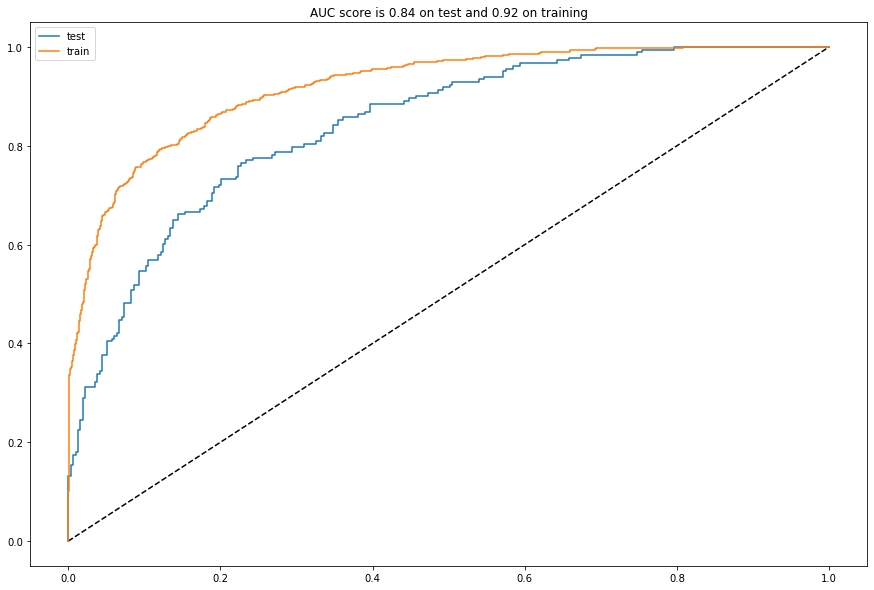

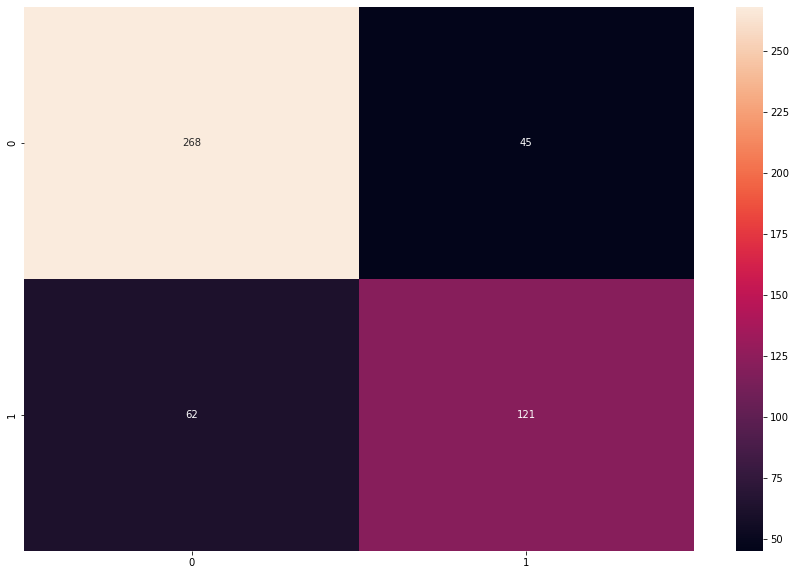

In [441]:
analyze(gb)

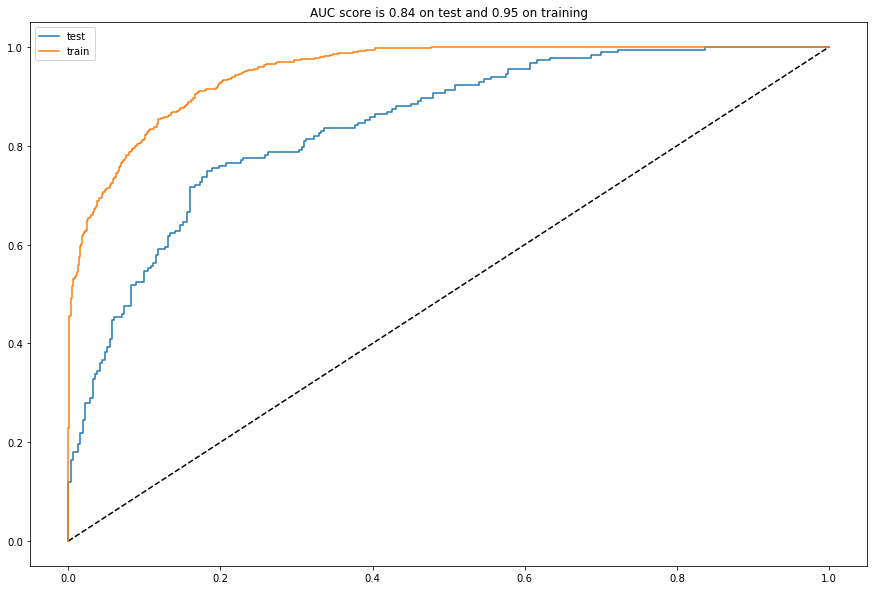

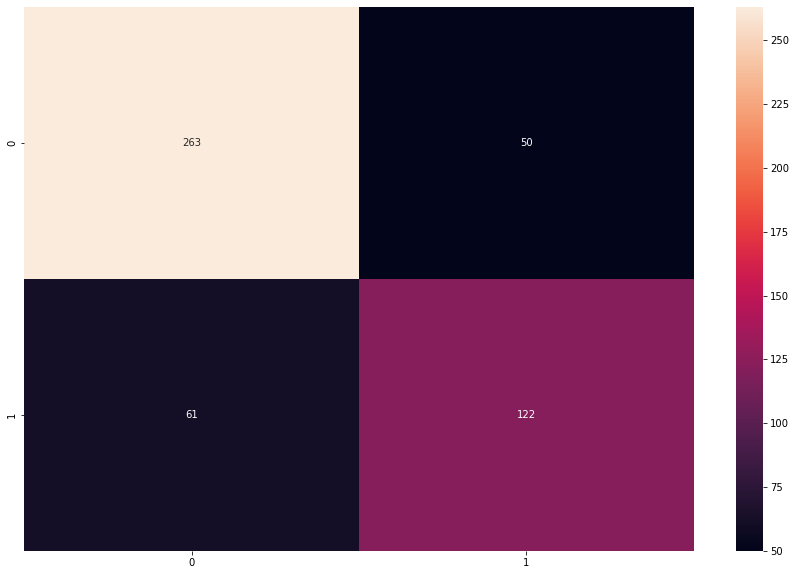

In [442]:
analyze(rf)

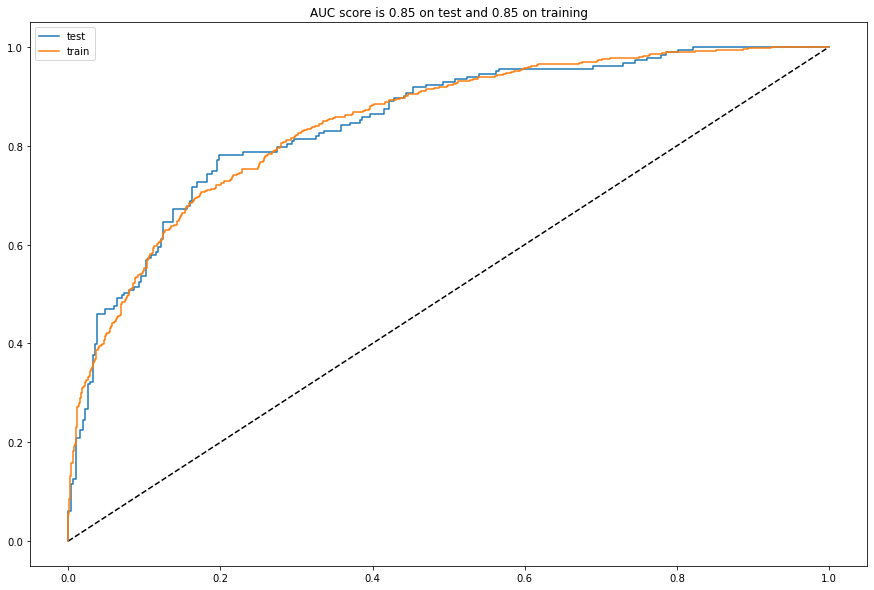

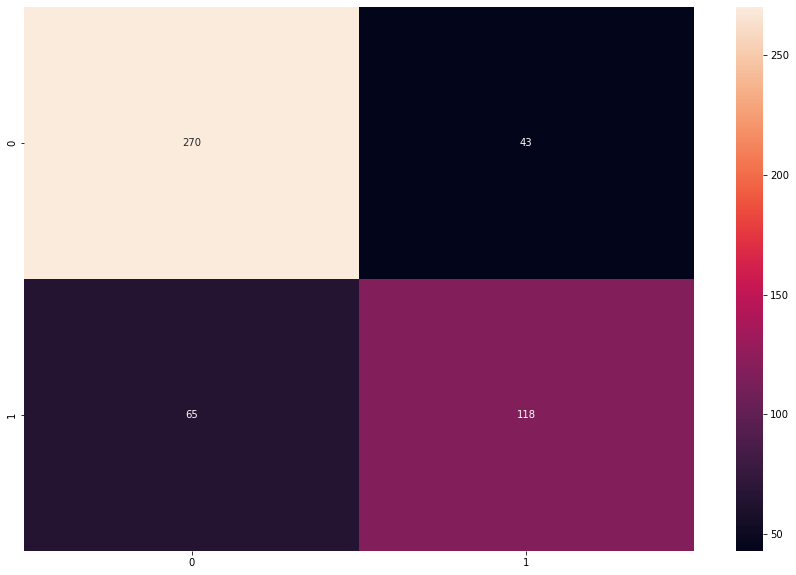

In [443]:
analyze(rlog)

The Random Forest model is a little bit better but seems to underfit. So, we will use the Gradient Boosting Model.

# Simulação da Copa

Para podermos simularmos os jogos, primeiramente vamos realizar um Web Scraping do Wikipédia para conseguirmos pegar os grupos, times e partidas da primeira fase. 

In [444]:
from operator import itemgetter

In [445]:
dfs = pd.read_html(r"https://en.wikipedia.org/wiki/2022_FIFA_World_Cup#Teams")

In [446]:
dfs[13]

,Pos,"Team.mw-parser-output .navbar{display:inline;font-size:88%;font-weight:normal}.mw-parser-output .navbar-collapse{float:left;text-align:left}.mw-parser-output .navbar-boxtext{word-spacing:0}.mw-parser-output .navbar ul{display:inline-block;white-space:nowrap;line-height:inherit}.mw-parser-output .navbar-brackets::before{margin-right:-0.125em;content:""[ ""}.mw-parser-output .navbar-brackets::after{margin-left:-0.125em;content:"" ]""}.mw-parser-output .navbar li{word-spacing:-0.125em}.mw-parser-output .navbar a>span,.mw-parser-output .navbar a>abbr{text-decoration:inherit}.mw-parser-output .navbar-mini abbr{font-variant:small-caps;border-bottom:none;text-decoration:none;cursor:inherit}.mw-parser-output .navbar-ct-full{font-size:114%;margin:0 7em}.mw-parser-output .navbar-ct-mini{font-size:114%;margin:0 4em}vte",Pld,W,D,L,GF,GA,GD,Pts,Qualification
0,1,Ecuador,1,1,0,0,2,0,+2,3,Advance to knockout stage
1,2,Senegal,0,0,0,0,0,0,0,0,Advance to knockout stage
2,3,Netherlands,0,0,0,0,0,0,0,0,NaN
3,4,Qatar (H),1,0,0,1,0,2,−2,0,NaN


In [447]:
matches = []
groups = ["A", "B", "C", "D", "E", "F", "G", "H"]
group_count = 0 

table = {}
#TABLE -> TEAM, POINTS, WIN PROBS (CRITERIO DE DESEMPATE)
table[groups[group_count]] = [[a.split(" ")[0], 0, []] for a in list(dfs[13].iloc[:, 1].values)]

In [448]:
for i in range(14, 69, 1):
    if len(dfs[i].columns) == 3:
        team_1 = dfs[i].columns.values[0]
        team_2 = dfs[i].columns.values[-1]
        matches.append((groups[group_count], team_1, team_2))
    else:
        group_count+=1
        table[groups[group_count]] = [[a, 0, []] for a in list(dfs[i].iloc[:, 1].values)]

In [449]:
import copy

In [450]:
table_rf = copy.deepcopy(table)
table_rlog = copy.deepcopy(table)

Com a construção do grupo e os participante, é possível armazenar os pontos dos times e a probabilidade de ganhar cada jogo. 

Caso exista empate nos pontos, a probabilidade de vencer vai ser usada como desempate (na realidade, é a verdadeira métrica para avanço).

In [457]:
matches[:10]

[('A', 'Qatar', 'Ecuador'),
 ('A', 'Senegal', 'Netherlands'),
 ('A', 'Qatar', 'Senegal'),
 ('A', 'Netherlands', 'Ecuador'),
 ('A', 'Ecuador', 'Senegal'),
 ('A', 'Netherlands', 'Qatar'),
 ('B', 'England', 'Iran'),
 ('B', 'United States', 'Wales'),
 ('B', 'Wales', 'Iran'),
 ('B', 'England', 'United States')]

Para a construção das variáveis vamos utilizar a última partida do time para que possamos pegar os valores de cada covariável.


In [463]:
team_stats_raw

,date,team,score,suf_score,rank,rank_suf,rank_change,total_points,result,rank_dif,points_by_rank,team_points,country_classification,points_by_classification
0,2018-07-01,Russia,1.0,1.0,49.0,6.0,-12.0,1758.00,2,43.0,0.166667,1,6,1.0
1,2018-07-01,Croatia,1.0,1.0,12.0,15.0,-6.0,2036.00,2,-3.0,0.066667,1,2,0.5
2,2018-07-02,Brazil,2.0,0.0,4.0,10.0,1.0,2160.00,0,-6.0,0.300000,3,1,1.5
3,2018-07-02,Belgium,3.0,2.0,5.0,41.0,-1.0,2124.00,0,-36.0,0.073171,3,1,0.75
4,2018-07-03,Sweden,1.0,0.0,21.0,8.0,-1.0,1955.00,0,13.0,0.375000,3,4,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3360,2022-09-27,Serbia,2.0,0.0,25.0,36.0,0.0,1549.53,1,11.0,0.083333,3,4,0.75
3361,2022-09-27,Slovenia,1.0,1.0,65.0,20.0,0.0,1372.48,2,-45.0,0.050000,1,6,0.25
3362,2022-09-27,Cyprus,1.0,5.0,108.0,106.0,1.0,1180.52,0,-2.0,0.000000,0,8,0.0
3363,2022-09-27,Northern Ireland,1.0,3.0,58.0,49.0,0.0,1399.10,0,-9.0,0.000000,0,6,0.0


In [486]:
def find_stats(team_1):
#team_1 = "Qatar"
    past_games = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date")
    last5 = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date").tail(5)

    team_1_rank = past_games["rank"].values[-1]
    team_1_goals = past_games['score'].mean()
    team_1_goals_l5 = last5['score'].mean()
    team_1_goals_suf = past_games['suf_score'].mean()
    team_1_goals_suf_l5 = last5['suf_score'].mean()
    team_1_rank_suf = past_games['rank_suf'].mean()
    team_1_rank_suf_l5 = last5['rank_suf'].mean()
    team_1_gp_rank = past_games['points_by_rank'].mean()
    team_1_gp_rank_l5 = last5['points_by_rank'].mean()
    team_1_points_by_classification = past_games['points_by_classification'].mean()

    return [team_1_rank, team_1_goals, team_1_goals_l5, team_1_goals_suf, team_1_goals_suf_l5, team_1_rank_suf, team_1_rank_suf_l5, team_1_gp_rank, team_1_gp_rank_l5, team_1_points_by_classification]

In [487]:
def find_features(team_1, team_2):
    rank_dif = team_1[0] - team_2[0]
    goals_dif = team_1[1] - team_2[1]
    goals_dif_l5 = team_1[2] - team_2[2]
    goals_suf_dif = team_1[3] - team_2[3]
    goals_suf_dif_l5 = team_1[4] - team_2[4]
    goals_per_ranking_dif = (team_1[1]/team_1[5]) - (team_2[1]/team_2[5])
    dif_rank_agst = team_1[5] - team_2[5]
    dif_rank_agst_l5 = team_1[6] - team_2[6]
    dif_gp_rank = team_1[7] - team_2[7]
    dif_gp_rank_l5 = team_1[8] - team_2[8]
    dif_points_by_classification = team_1[9] - team_2[9]
    
    return [rank_dif, goals_dif, goals_dif_l5, goals_suf_dif, goals_suf_dif_l5, goals_per_ranking_dif, dif_rank_agst, dif_rank_agst_l5, dif_gp_rank, dif_gp_rank_l5, 1, 0, dif_points_by_classification]

Now, we are able to simulate.

Since the model simulates if team 1 will win or not win, it's needed to create some criteria to define a draw. Also, since we have not home advantage at World Cup, the idea is to predict game two times, changing team 1 and team 2. The team with the highest mean of probabilities will be assigned as winner. At the group phase, if "home team" win as team 1 and loses as team 2, or if "home team" win as team 2 and loses at team 1, there will be assigned a draw in that match.

In [488]:
X.columns

Index(['rank_dif', 'goals_dif', 'goals_dif_l5', 'goals_suf_dif',
       'goals_suf_dif_l5', 'goals_per_ranking_dif', 'dif_rank_agst',
       'dif_rank_agst_l5', 'dif_points_rank', 'dif_points_rank_l5',
       'is_friendly_0', 'is_friendly_1', 'dif_points_by_classification',
       'dif_points_by_classification_l5'],
      dtype='object')

In [489]:
advanced_group = []
last_group = ""

for k in table.keys():
    for t in table[k]:
        t[1] = 0
        t[2] = []
        
for teams in matches:
    draw = False
    team_1 = find_stats(teams[1])
    team_2 = find_stats(teams[2])

    

    features_g1 = find_features(team_1, team_2)
    features_g2 = find_features(team_2, team_1)

    probs_g1 = gb.predict_proba([features_g1])
    probs_g2 = gb.predict_proba([features_g2])
    
    team_1_prob_g1 = probs_g1[0][0] # Probabilidade de vitória do time 1 em casa
    team_1_prob_g2 = probs_g2[0][1] # Probabilidade de vitória do time 1 fora de casa
    team_2_prob_g1 = probs_g1[0][1] # Probabilidade de vitória do time 2 fora de casa
    team_2_prob_g2 = probs_g2[0][0] # Probabilidade de vitória do time 2 em casa

    team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
    team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
    
    if ((team_1_prob_g1 > team_2_prob_g1) & (team_2_prob_g2 > team_1_prob_g2)) | ((team_1_prob_g1 < team_2_prob_g1) & (team_2_prob_g2 < team_1_prob_g2)):
        draw=True
        for i in table[teams[0]]:
            if i[0] == teams[1] or i[0] == teams[2]:
                i[1] += 1
                
    elif team_1_prob > team_2_prob:
        winner = teams[1]
        winner_proba = team_1_prob
        for i in table[teams[0]]:
            if i[0] == teams[1]:
                i[1] += 3
                
    elif team_2_prob > team_1_prob:  
        winner = teams[2]
        winner_proba = team_2_prob
        for i in table[teams[0]]:
            if i[0] == teams[2]:
                i[1] += 3
    
    for i in table[teams[0]]: #adding criterio de desempate (probs por jogo)
            if i[0] == teams[1]:
                i[2].append(team_1_prob)
            if i[0] == teams[2]:
                i[2].append(team_2_prob)

    if last_group != teams[0]:
        if last_group != "":
            print("\n")
            print("Grupo %s classificados: "%(last_group))
            
            for i in table[last_group]: #adding crieterio de desempate
                i[2] = np.mean(i[2])
            
            final_points = table[last_group]
            final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
            advanced_group.append([final_table[0][0], final_table[1][0]])
            for i in final_table:
                print("%s -------- %d"%(i[0], i[1]))
        print("\n")
        print("-"*10+" Começando a simulação para o Grupo %s "%(teams[0])+"-"*10)
        
        
    if draw == False:
        print("Grupo %s - %s x %s: vencedor %s com %.2f probabilidade"%(teams[0], teams[1], teams[2], winner, winner_proba))
    else:
        print("Grupo %s - %s x %s: Empate"%(teams[0], teams[1], teams[2]))
    last_group =  teams[0]

print("\n")
print("Group %s advanced: "%(last_group))

for i in table[last_group]: #adding crieterio de desempate
    i[2] = np.mean(i[2])
            
final_points = table[last_group]
final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
advanced_group.append([final_table[0][0], final_table[1][0]])
for i in final_table:
    print("%s -------- %d"%(i[0], i[1]))



---------- Começando a simulação para o Grupo A ----------
Grupo A - Qatar x Ecuador: vencedor Ecuador com 0.68 probabilidade
Grupo A - Senegal x Netherlands: vencedor Netherlands com 0.68 probabilidade
Grupo A - Qatar x Senegal: Empate
Grupo A - Netherlands x Ecuador: vencedor Netherlands com 0.79 probabilidade
Grupo A - Ecuador x Senegal: vencedor Ecuador com 0.55 probabilidade
Grupo A - Netherlands x Qatar: vencedor Netherlands com 0.80 probabilidade


Grupo A classificados: 
Netherlands -------- 9
Ecuador -------- 6
Senegal -------- 1
Qatar -------- 1


---------- Começando a simulação para o Grupo B ----------
Grupo B - England x Iran: vencedor England com 0.69 probabilidade
Grupo B - United States x Wales: Empate
Grupo B - Wales x Iran: Empate
Grupo B - England x United States: vencedor England com 0.70 probabilidade
Grupo B - Wales x England: vencedor England com 0.72 probabilidade
Grupo B - Iran x United States: Empate


Grupo B classificados: 
England -------- 9
Wales ------

The group phase predicted no surprises, or maybe the draw between Brazil and Switzerland or France and Denmark. For the playoffs phase, I'll predict and show it graphically as made [here](https://www.kaggle.com/code/agostontorok/soccer-world-cup-2018-winner). 

In [490]:
advanced = advanced_group

In [491]:
advanced

[['Netherlands', 'Ecuador'],
 ['England', 'Wales'],
 ['Argentina', 'Mexico'],
 ['France', 'Denmark'],
 ['Spain', 'Germany'],
 ['Belgium', 'Croatia'],
 ['Brazil', 'Switzerland'],
 ['Portugal', 'Uruguay']]

In [492]:
playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}

In [493]:
for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []

for p in playoffs.keys():
    if p == "Round of 16":
        control = []
        for a in range(0, len(advanced*2), 1):
            if a < len(advanced):
                if a % 2 == 0:
                    control.append((advanced*2)[a][0])
                else:
                    control.append((advanced*2)[a][1])
            else:
                if a % 2 == 0:
                    control.append((advanced*2)[a][1])
                else:
                    control.append((advanced*2)[a][0])

        playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
        
        for i in range(0, len(playoffs[p]), 1):
            game = playoffs[p][i]
            
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)

            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
        
    else:
        playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
        next_rounds = []
        for i in range(0, len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)
            
            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
            

----------
Starting simulation of Round of 16
----------


Netherlands vs. Wales: Netherlands advances with prob 0.74
Argentina vs. Denmark: Argentina advances with prob 0.63
Spain vs. Croatia: Spain advances with prob 0.67
Brazil vs. Uruguay: Brazil advances with prob 0.74
Ecuador vs. England: England advances with prob 0.72
Mexico vs. France: France advances with prob 0.72
Germany vs. Belgium: Belgium advances with prob 0.66
Switzerland vs. Portugal: Portugal advances with prob 0.60
----------
Starting simulation of Quarter-Final
----------


Netherlands vs. Argentina: Netherlands advances with prob 0.51
Spain vs. Brazil: Brazil advances with prob 0.53
England vs. France: France advances with prob 0.58
Belgium vs. Portugal: Belgium advances with prob 0.60
----------
Starting simulation of Semi-Final
----------


Netherlands vs. Brazil: Brazil advances with prob 0.58
France vs. Belgium: Belgium advances with prob 0.50
----------
Starting simulation of Final
----------


Brazil vs. Bel

## Random forest

In [494]:
table = table_rf

In [495]:
advanced_group = []
last_group = ""

for k in table.keys():
    for t in table[k]:
        t[1] = 0
        t[2] = []
        
for teams in matches:
    draw = False
    team_1 = find_stats(teams[1])
    team_2 = find_stats(teams[2])

    

    features_g1 = find_features(team_1, team_2)
    features_g2 = find_features(team_2, team_1)

    probs_g1 = rf.predict_proba([features_g1])
    probs_g2 = rf.predict_proba([features_g2])
    
    team_1_prob_g1 = probs_g1[0][0] # Probabilidade de vitória do time 1 em casa
    team_1_prob_g2 = probs_g2[0][1] # Probabilidade de vitória do time 1 fora de casa
    team_2_prob_g1 = probs_g1[0][1] # Probabilidade de vitória do time 2 fora de casa
    team_2_prob_g2 = probs_g2[0][0] # Probabilidade de vitória do time 2 em casa

    team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
    team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
    
    if ((team_1_prob_g1 > team_2_prob_g1) & (team_2_prob_g2 > team_1_prob_g2)) | ((team_1_prob_g1 < team_2_prob_g1) & (team_2_prob_g2 < team_1_prob_g2)):
        draw=True
        for i in table[teams[0]]:
            if i[0] == teams[1] or i[0] == teams[2]:
                i[1] += 1
                
    elif team_1_prob > team_2_prob:
        winner = teams[1]
        winner_proba = team_1_prob
        for i in table[teams[0]]:
            if i[0] == teams[1]:
                i[1] += 3
                
    elif team_2_prob > team_1_prob:  
        winner = teams[2]
        winner_proba = team_2_prob
        for i in table[teams[0]]:
            if i[0] == teams[2]:
                i[1] += 3
    
    for i in table[teams[0]]: #adding criterio de desempate (probs por jogo)
            if i[0] == teams[1]:
                i[2].append(team_1_prob)
            if i[0] == teams[2]:
                i[2].append(team_2_prob)

    if last_group != teams[0]:
        if last_group != "":
            print("\n")
            print("Grupo %s classificados: "%(last_group))
            
            for i in table[last_group]: #adding crieterio de desempate
                i[2] = np.mean(i[2])
            
            final_points = table[last_group]
            final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
            advanced_group.append([final_table[0][0], final_table[1][0]])
            for i in final_table:
                print("%s -------- %d"%(i[0], i[1]))
        print("\n")
        print("-"*10+" Começando a simulação para o Grupo %s "%(teams[0])+"-"*10)
        
        
    if draw == False:
        print("Grupo %s - %s x %s: vencedor %s com %.2f probabilidade"%(teams[0], teams[1], teams[2], winner, winner_proba))
    else:
        print("Grupo %s - %s x %s: Empate"%(teams[0], teams[1], teams[2]))
    last_group =  teams[0]

print("\n")
print("Group %s advanced: "%(last_group))

for i in table[last_group]: #adding crieterio de desempate
    i[2] = np.mean(i[2])
            
final_points = table[last_group]
final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
advanced_group.append([final_table[0][0], final_table[1][0]])
for i in final_table:
    print("%s -------- %d"%(i[0], i[1]))



---------- Começando a simulação para o Grupo A ----------
Grupo A - Qatar x Ecuador: vencedor Ecuador com 0.64 probabilidade
Grupo A - Senegal x Netherlands: vencedor Netherlands com 0.73 probabilidade
Grupo A - Qatar x Senegal: Empate
Grupo A - Netherlands x Ecuador: vencedor Netherlands com 0.83 probabilidade
Grupo A - Ecuador x Senegal: vencedor Ecuador com 0.54 probabilidade
Grupo A - Netherlands x Qatar: vencedor Netherlands com 0.86 probabilidade


Grupo A classificados: 
Netherlands -------- 9
Ecuador -------- 6
Senegal -------- 1
Qatar -------- 1


---------- Começando a simulação para o Grupo B ----------
Grupo B - England x Iran: vencedor England com 0.72 probabilidade
Grupo B - United States x Wales: Empate
Grupo B - Wales x Iran: Empate
Grupo B - England x United States: vencedor England com 0.71 probabilidade
Grupo B - Wales x England: vencedor England com 0.78 probabilidade
Grupo B - Iran x United States: vencedor United States com 0.59 probabilidade


Grupo B classifi

In [496]:
advanced = advanced_group

In [497]:
advanced

[['Netherlands', 'Ecuador'],
 ['England', 'United States'],
 ['Argentina', 'Mexico'],
 ['France', 'Denmark'],
 ['Spain', 'Germany'],
 ['Belgium', 'Croatia'],
 ['Brazil', 'Switzerland'],
 ['Portugal', 'Uruguay']]

In [498]:
playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}

In [499]:
for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []

for p in playoffs.keys():
    if p == "Round of 16":
        control = []
        for a in range(0, len(advanced*2), 1):
            if a < len(advanced):
                if a % 2 == 0:
                    control.append((advanced*2)[a][0])
                else:
                    control.append((advanced*2)[a][1])
            else:
                if a % 2 == 0:
                    control.append((advanced*2)[a][1])
                else:
                    control.append((advanced*2)[a][0])

        playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
        
        for i in range(0, len(playoffs[p]), 1):
            game = playoffs[p][i]
            
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)

            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = rf.predict_proba([features_g1])
            probs_g2 = rf.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
        
    else:
        playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
        next_rounds = []
        for i in range(0, len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)
            
            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = rf.predict_proba([features_g1])
            probs_g2 = rf.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
            

----------
Starting simulation of Round of 16
----------


Netherlands vs. United States: Netherlands advances with prob 0.60
Argentina vs. Denmark: Argentina advances with prob 0.63
Spain vs. Croatia: Spain advances with prob 0.67
Brazil vs. Uruguay: Brazil advances with prob 0.75
Ecuador vs. England: England advances with prob 0.75
Mexico vs. France: France advances with prob 0.72
Germany vs. Belgium: Belgium advances with prob 0.68
Switzerland vs. Portugal: Portugal advances with prob 0.60
----------
Starting simulation of Quarter-Final
----------


Netherlands vs. Argentina: Argentina advances with prob 0.56
Spain vs. Brazil: Brazil advances with prob 0.53
England vs. France: France advances with prob 0.59
Belgium vs. Portugal: Belgium advances with prob 0.62
----------
Starting simulation of Semi-Final
----------


Argentina vs. Brazil: Argentina advances with prob 0.51
France vs. Belgium: Belgium advances with prob 0.54
----------
Starting simulation of Final
----------


Argenti

## Regressão Logística

In [500]:
table = table_rlog

In [501]:
advanced_group = []
last_group = ""

for k in table.keys():
    for t in table[k]:
        t[1] = 0
        t[2] = []
        
for teams in matches:
    draw = False
    team_1 = find_stats(teams[1])
    team_2 = find_stats(teams[2])

    

    features_g1 = find_features(team_1, team_2)
    features_g2 = find_features(team_2, team_1)

    probs_g1 = rlog.predict_proba([features_g1])
    probs_g2 = rlog.predict_proba([features_g2])
    
    team_1_prob_g1 = probs_g1[0][0] # Probabilidade de vitória do time 1 em casa
    team_1_prob_g2 = probs_g2[0][1] # Probabilidade de vitória do time 1 fora de casa
    team_2_prob_g1 = probs_g1[0][1] # Probabilidade de vitória do time 2 fora de casa
    team_2_prob_g2 = probs_g2[0][0] # Probabilidade de vitória do time 2 em casa

    team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
    team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
    
    if ((team_1_prob_g1 > team_2_prob_g1) & (team_2_prob_g2 > team_1_prob_g2)) | ((team_1_prob_g1 < team_2_prob_g1) & (team_2_prob_g2 < team_1_prob_g2)):
        draw=True
        for i in table[teams[0]]:
            if i[0] == teams[1] or i[0] == teams[2]:
                i[1] += 1
                
    elif team_1_prob > team_2_prob:
        winner = teams[1]
        winner_proba = team_1_prob
        for i in table[teams[0]]:
            if i[0] == teams[1]:
                i[1] += 3
                
    elif team_2_prob > team_1_prob:  
        winner = teams[2]
        winner_proba = team_2_prob
        for i in table[teams[0]]:
            if i[0] == teams[2]:
                i[1] += 3
    
    for i in table[teams[0]]: #adding criterio de desempate (probs por jogo)
            if i[0] == teams[1]:
                i[2].append(team_1_prob)
            if i[0] == teams[2]:
                i[2].append(team_2_prob)

    if last_group != teams[0]:
        if last_group != "":
            print("\n")
            print("Grupo %s classificados: "%(last_group))
            
            for i in table[last_group]: #adding crieterio de desempate
                i[2] = np.mean(i[2])
            
            final_points = table[last_group]
            final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
            advanced_group.append([final_table[0][0], final_table[1][0]])
            for i in final_table:
                print("%s -------- %d"%(i[0], i[1]))
        print("\n")
        print("-"*10+" Começando a simulação para o Grupo %s "%(teams[0])+"-"*10)
        
        
    if draw == False:
        print("Grupo %s - %s x %s: vencedor %s com %.2f probabilidade"%(teams[0], teams[1], teams[2], winner, winner_proba))
    else:
        print("Grupo %s - %s x %s: Empate"%(teams[0], teams[1], teams[2]))
    last_group =  teams[0]

print("\n")
print("Group %s advanced: "%(last_group))

for i in table[last_group]: #adding crieterio de desempate
    i[2] = np.mean(i[2])
            
final_points = table[last_group]
final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
advanced_group.append([final_table[0][0], final_table[1][0]])
for i in final_table:
    print("%s -------- %d"%(i[0], i[1]))



---------- Começando a simulação para o Grupo A ----------
Grupo A - Qatar x Ecuador: vencedor Ecuador com 0.64 probabilidade
Grupo A - Senegal x Netherlands: vencedor Netherlands com 0.71 probabilidade
Grupo A - Qatar x Senegal: vencedor Senegal com 0.62 probabilidade
Grupo A - Netherlands x Ecuador: vencedor Netherlands com 0.69 probabilidade
Grupo A - Ecuador x Senegal: Empate
Grupo A - Netherlands x Qatar: vencedor Netherlands com 0.80 probabilidade


Grupo A classificados: 
Netherlands -------- 9
Ecuador -------- 4
Senegal -------- 4
Qatar -------- 0


---------- Começando a simulação para o Grupo B ----------
Grupo B - England x Iran: vencedor England com 0.65 probabilidade
Grupo B - United States x Wales: Empate
Grupo B - Wales x Iran: Empate
Grupo B - England x United States: Empate
Grupo B - Wales x England: vencedor England com 0.63 probabilidade
Grupo B - Iran x United States: Empate


Grupo B classificados: 
England -------- 7
United States -------- 3
Wales -------- 2
Ira

In [502]:
advanced = advanced_group

In [503]:
advanced

[['Netherlands', 'Ecuador'],
 ['England', 'United States'],
 ['Argentina', 'Mexico'],
 ['France', 'Denmark'],
 ['Spain', 'Germany'],
 ['Belgium', 'Croatia'],
 ['Brazil', 'Switzerland'],
 ['Portugal', 'Uruguay']]

In [504]:
playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}

In [505]:
for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []

for p in playoffs.keys():
    if p == "Round of 16":
        control = []
        for a in range(0, len(advanced*2), 1):
            if a < len(advanced):
                if a % 2 == 0:
                    control.append((advanced*2)[a][0])
                else:
                    control.append((advanced*2)[a][1])
            else:
                if a % 2 == 0:
                    control.append((advanced*2)[a][1])
                else:
                    control.append((advanced*2)[a][0])

        playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
        
        for i in range(0, len(playoffs[p]), 1):
            game = playoffs[p][i]
            
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)

            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = rlog.predict_proba([features_g1])
            probs_g2 = rlog.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
        
    else:
        playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
        next_rounds = []
        for i in range(0, len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)
            
            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = rlog.predict_proba([features_g1])
            probs_g2 = rlog.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
            

----------
Starting simulation of Round of 16
----------


Netherlands vs. United States: Netherlands advances with prob 0.59
Argentina vs. Denmark: Argentina advances with prob 0.62
Spain vs. Croatia: Spain advances with prob 0.58
Brazil vs. Uruguay: Brazil advances with prob 0.63
Ecuador vs. England: England advances with prob 0.66
Mexico vs. France: France advances with prob 0.60
Germany vs. Belgium: Belgium advances with prob 0.59
Switzerland vs. Portugal: Portugal advances with prob 0.63
----------
Starting simulation of Quarter-Final
----------


Netherlands vs. Argentina: Argentina advances with prob 0.58
Spain vs. Brazil: Brazil advances with prob 0.61
England vs. France: France advances with prob 0.52
Belgium vs. Portugal: Belgium advances with prob 0.52
----------
Starting simulation of Semi-Final
----------


Argentina vs. Brazil: Brazil advances with prob 0.55
France vs. Belgium: Belgium advances with prob 0.56
----------
Starting simulation of Final
----------


Brazil vs.

In [506]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

In [507]:
plt.figure(figsize=(15, 10))
G = nx.balanced_tree(2, 3)


labels = []


for p in playoffs.keys():
    for game in playoffs[p]:
        label = f"{game[0]}({round(game[2][0], 2)}) \n {game[1]}({round(game[2][1], 2)})"
        labels.append(label)
    
labels_dict = {}
labels_rev = list(reversed(labels))

for l in range(len(list(G.nodes))):
    labels_dict[l] = labels_rev[l]

pos = graphviz_layout(G, prog='twopi')
labels_pos = {n: (k[0], k[1]-0.08*k[1]) for n,k in pos.items()}
center  = pd.DataFrame(pos).mean(axis=1).mean()
    

nx.draw(G, pos = pos, with_labels=False, node_color=range(15), edge_color="#bbf5bb", width=10, font_weight='bold',cmap=plt.cm.Greens, node_size=5000)
nx.draw_networkx_labels(G, pos = labels_pos, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=labels_dict)
texts = ["Round \nof 16", "Quarter \n Final", "Semi \n Final", "Final\n"]
pos_y = pos[0][1] + 55
for text in reversed(texts):
    pos_x = center
    pos_y -= 75 
    plt.text(pos_y, pos_x, text, fontsize = 18)

plt.axis('equal')
plt.show()

ModuleNotFoundError: No module named 'pydot'

<Figure size 1080x720 with 0 Axes>

And that's the final simulation! Brazil has won the 6th title! Hoping that my predictions are correct now. 

It's nice to analyze too the possible upsets. Belgium passed against Germany, and were defeated by Portugal. Argentina - Netherlands game is very tight, with Netherlands passing by nearly 1%. The same happens between France and England, with England passing. I think England as finalist was the biggest upset of the simulation.

# Conclusion

The goal of this was to improve my knowledge with Machine Learning simulating something that I love (Football World Cup). I think that's amazing to create models that we can see the result in real life, and that's what is going to happen!

In general, I think that the model predicted like the common sense of people who watch football. There are not huge surprises in the simulation. It's also nice to see games with teams that are more unkown in group phase, like Iran vs. Wales or Senegal vs. Ecuador. I think that in games like that, the model is a good guidance to betting, since the knowledge of most people second tier national teams is not great.